# IllustrisTNG : Experimenting with extracting various information/quantities for use in Lenstronomy

In [1]:
#ILLUSTRIS_TNG


import os
import requests
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Hubble parameter from TNG cosmology
h = 0.6774

In [2]:
# API configuration
API_KEY = os.getenv("TNG_API_KEY")
HEADERS = {"api-key": "4d3728701fffb127589a0a0fe475db79"}

def get(url, params=None):
    """
    Helper function to perform GET requests from the IllustrisTNG API.
    If a JSON response is returned, parse and return it as a dict.
    If a file is returned (has a 'content-disposition' header),
    save it locally and return the filename.
    Otherwise, return the raw requests.Response object.
    """
    # make HTTP GET request to path
    response = requests.get(url, params=params, headers=HEADERS)

    # raise exception if response code is not HTTP SUCCESS (200)
    response.raise_for_status()  # raise an exception for HTTP errors

    # If the response is JSON, parse and return as a dict:
    if response.headers.get("content-type") == "application/json":
        return response.json()   # parse json responses automatically

    # If this is a file download, save to disk and return the local filename
    if "content-disposition" in response.headers:
        # e.g. 'attachment; filename="cutout_12345.hdf5"'
        cd = response.headers["content-disposition"]
        # Extract the actual filename:
        filename = cd.split("filename=")[1].strip(';"')
        with open(filename, "wb") as f:
            f.write(response.content)
        return filename

    # Otherwise just return the raw response:
    return response

In [3]:

baseUrl = 'http://www.tng-project.org/api/'
response = get(baseUrl)
print(response.keys(), len(response['simulations']))

#%%

print(response['simulations'][0])
names = [sim['name'] for sim in response['simulations']]
for i in names :
  print(i)


dict_keys(['simulations']) 66
{'name': 'Illustris-1', 'num_snapshots': 134, 'url': 'http://www.tng-project.org/api/Illustris-1/'}
Illustris-1
Illustris-1-Dark
Illustris-2
Illustris-2-Dark
Illustris-3
Illustris-3-Dark
TNG100-1
TNG100-1-Dark
TNG100-2
TNG100-2-Dark
TNG100-3
TNG100-3-Dark
TNG300-3
TNG300-2-Dark
TNG300-2
TNG300-1-Dark
TNG300-1
TNG300-3-Dark
TNG50-1
TNG50-1-Dark
TNG50-2
TNG50-2-Dark
TNG50-3
TNG50-3-Dark
TNG50-4
TNG50-4-Dark
TNG-Cluster
Illustris-1-Subbox0
Illustris-1-Subbox1
Illustris-1-Subbox2
Illustris-1-Subbox3
Illustris-2-Subbox0
Illustris-2-Subbox1
Illustris-2-Subbox2
Illustris-2-Subbox3
Illustris-3-Subbox0
Illustris-3-Subbox1
Illustris-3-Subbox2
Illustris-3-Subbox3
TNG100-1-Subbox0
TNG100-1-Subbox1
TNG100-2-Subbox0
TNG100-2-Subbox1
TNG100-3-Subbox0
TNG100-3-Subbox1
TNG300-3-Subbox1
TNG300-3-Subbox2
TNG300-3-Subbox0
TNG300-2-Subbox1
TNG300-2-Subbox2
TNG300-2-Subbox0
TNG300-1-Subbox1
TNG300-1-Subbox2
TNG300-1-Subbox0
TNG50-1-Subbox0
TNG50-1-Subbox2
TNG50-1-Subbox1
TNG50-

In [4]:
#%%  Selecting Subhalos within a Mass Range, and storing stellar, gas and DM mass and sSFR
"""
Key : \\
Halo $-$ Galaxy Cluster \\
Subhalo $-$ individual galaxy within cluster """

# Redshift of interest
z_snap = 0.5

# for Illustris-1 at 𝑧=0, search for all subhalos with total mass mass_min Solar<𝑀<mass_max Solar
# print the number returned, and the Subfind IDs of the first five results

base_url = "http://www.tng-project.org/api/TNG100-1/"

# Snapshot-to-redshift mapping (not needed, just in case)
snapshots_url = base_url+"/snapshots/"
snapshots_data = get(snapshots_url)
snap_to_z = {snap['number']: snap['redshift'] for snap in snapshots_data}

# first convert log solar masses into group catalog units
mass_min = 10**12.5 / 1e10 * 0.704
mass_max = 10**13. / 1e10 * 0.704

# form the search_query string by hand for once
search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)

# form the url and make the request
url = base_url+f"snapshots/z={z_snap}/subhalos/" + search_query
print(f"URL constructed: {url}")

# Set the limit
subhalos = get(url, {'limit':1000})
print('Number of sub-halos satisfying mass criterion:', subhalos['count'])

nids = 300
ids = [subhalos['results'][i]['id'] for i in range(min(nids, len(subhalos['results'])))]

print(f"First 10 IDs: {ids[0:10]}")

# Create a list to store the sSFR results for each subhalo
ssfr_data = []

# Loop through the subhalo list to compute sSFR for each subhalo
counter = 0
for sub in subhalos['results']:
    # Retrieve detailed info for the subhalo
    sub_detail = get(sub['url'])

    # Extract star formation rate and stellar mass etc
    sfr = sub_detail.get('sfr', None)
    mass_stars = sub_detail.get('mass_stars', None)
    mass_gas = sub_detail.get('mass_gas', None)
    mass_dm = sub_detail.get('mass_dm', None)

    # Check if mass_stars is valid (non-zero) to avoid division by zero
    if sfr is not None and mass_stars is not None and mass_stars > 0:
        sSFR = sfr / mass_stars
    else:
        sSFR = 0

    print(f"{counter} Subhalo ID {sub['id']}: SFR = {sfr}, Stellar Mass = {mass_stars}, Gas Mass = {mass_gas}, sSFR = {sSFR}")

     # Store the subhalo's id and computed sSFR (along with sfr and mass_stars for reference)
    ssfr_data.append({
        'id': sub['id'],
        'sfr': sfr,
        'mass_stars': mass_stars,
        'mass_gas': mass_gas,
        'mass_dm': mass_dm,
        'sSFR': sSFR
    })
    counter += 1

URL constructed: http://www.tng-project.org/api/TNG100-1/snapshots/z=0.5/subhalos/?mass__gt=222.62434727585392&mass__lt=704.0
Number of sub-halos satisfying mass criterion: 432
First 10 IDs: [1, 2, 4, 7308, 14589, 14590, 20423, 25816, 38201, 42431]
0 Subhalo ID 1: SFR = 22.9318, Stellar Mass = 21.5997, Gas Mass = 5.50427, sSFR = 1.0616721528539748
1 Subhalo ID 2: SFR = 4.61434, Stellar Mass = 13.797, Gas Mass = 6.35783, sSFR = 0.3344451692396898
2 Subhalo ID 4: SFR = 0.016279, Stellar Mass = 6.92472, Gas Mass = 1.01952, sSFR = 0.0023508531752908417
3 Subhalo ID 7308: SFR = 43.5521, Stellar Mass = 35.0372, Gas Mass = 5.64663, sSFR = 1.2430245567568186
4 Subhalo ID 14589: SFR = 4.39916, Stellar Mass = 20.118, Gas Mass = 17.7127, sSFR = 0.21866785962819368
5 Subhalo ID 14590: SFR = 12.2529, Stellar Mass = 10.2687, Gas Mass = 28.287, sSFR = 1.1932279645914283
6 Subhalo ID 20423: SFR = 0.478383, Stellar Mass = 12.3895, Gas Mass = 3.67499, sSFR = 0.03861196981314823
7 Subhalo ID 25816: SFR =

<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_97003/940001147.py:21: SyntaxWarning: invalid escape sequence '\o'
  axs[0].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_97003/940001147.py:31: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('DM Mass [$10^{10} M_{\odot}$]')
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_97003/940001147.py:38: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T

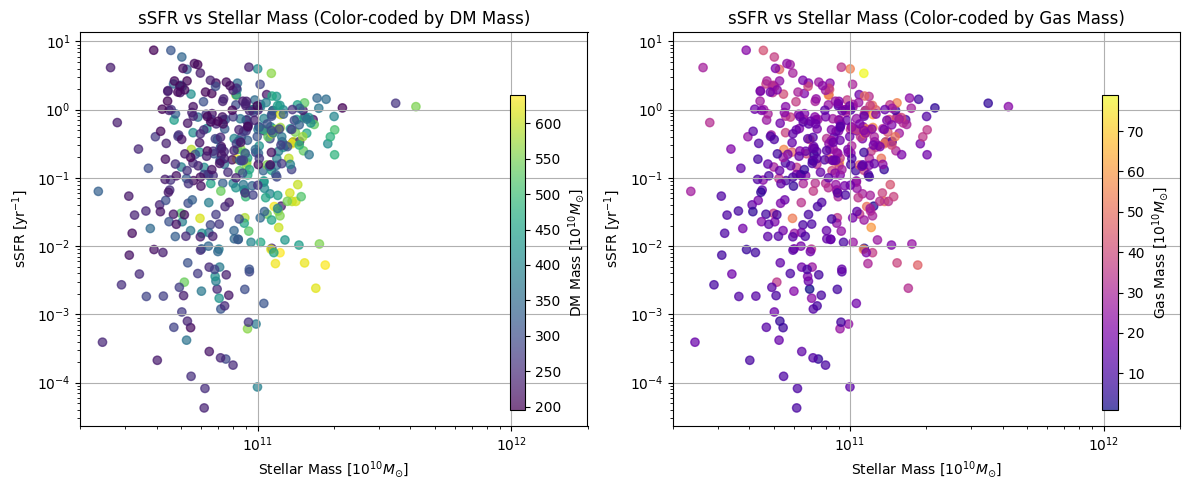

In [5]:
#%% Show Plots of selected subhalo properties

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Extract sSFR and stellar mass values from ssfr_data
stellar_mass = [entry['mass_stars'] for entry in ssfr_data]

dm_mass = [entry['mass_dm'] for entry in ssfr_data]
ssfr_values = [entry['sSFR'] for entry in ssfr_data]

# Create a figure with two subplots of equal width
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

# Set the x-axis limits for both subplots
axs[0].set_xlim(2e10, 2e12)
axs[1].set_xlim(2e10, 2e12)

# First subplot: sSFR vs Stellar Mass color-coded by Dark Matter Mass
sc0 = axs[0].scatter(1e+10*np.array(stellar_mass), ssfr_values, c=dm_mass, cmap='viridis', alpha=0.7)
axs[0].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
axs[0].set_ylabel('sSFR [yr$^{-1}$]')
axs[0].set_title('sSFR vs Stellar Mass (Color-coded by DM Mass)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid(True)

# Add a colorbar inside the right subplot without affecting its width
cax = inset_axes(axs[0], width="3%", height="80%", loc='upper right', borderpad=4.5)
cbar = fig.colorbar(sc0, cax=cax)
cbar.set_label('DM Mass [$10^{10} M_{\odot}$]')

# Extract gas mass values from ssfr_data
gas_mass = [entry['mass_gas'] for entry in ssfr_data]

# Second subplot: sSFR vs Stellar Mass color-coded by Gas Mass
sc1 = axs[1].scatter(1e+10*np.array(stellar_mass), ssfr_values, c=gas_mass, cmap='plasma', alpha=0.7)
axs[1].set_xlabel('Stellar Mass [$10^{10} M_{\odot}$]')
axs[1].set_ylabel('sSFR [yr$^{-1}$]')
axs[1].set_title('sSFR vs Stellar Mass (Color-coded by Gas Mass)')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid(True)

# Add a colorbar inside the right subplot without affecting its width
cax = inset_axes(axs[1], width="3%", height="80%", loc='upper right', borderpad=4.5)
cbar = fig.colorbar(sc1, cax=cax)
cbar.set_label('Gas Mass [$10^{10} M_{\odot}$]')

plt.tight_layout()
plt.show()

In [6]:
# Set the sSFR threshold
ssfr_threshold = 1e-4

# Set the stellar mass threshold
stellar_mass_threshold = 10e+10

# Find the indices of subhalos that satisfy the sSFR threshold
selected_indices = [i for i, entry in enumerate(ssfr_data) if (entry['sSFR'] < ssfr_threshold) & (1e+10*entry['mass_stars'] > stellar_mass_threshold)]
print(selected_indices)

# Request the subhalo details and snapshot cutout for stars
id_num = 0
id_num = selected_indices[id_num]

subhalo_url = base_url + f"snapshots/z={z_snap}/subhalos/" + str(ids[id_num]) + "/"
subhalo = get(subhalo_url)

print('Sub-halo center:', subhalo['pos_x'], subhalo['pos_y'], subhalo['pos_z'])
print('Sub-halo velocity:', subhalo['vel_x'], subhalo['vel_y'], subhalo['vel_z'])

# Request star particle data (Coordinates, Velocities, Masses)
cutout_url = subhalo_url + "cutout.hdf5"

print("Downloading sub-halo cutout file...")
cutout_request = {'dm': 'Coordinates,Velocities',
    'stars': 'Coordinates,Velocities,Masses,GFM_StellarFormationTime,GFM_Metallicity',
    'gas': 'Coordinates,Masses' }
cutout = get(cutout_url, cutout_request)

# To track where the subhalo’s stars originated,
# get the main progenitor branch (MPB) from the merger tree:
#tree_url = subhalo['trees']['sublink_mpb']  # Main progenitor branch
#tree_file = get(tree_url)

# Load the merger tree
#print("Loading the merger tree...")
#with h5py.File(tree_file, 'r') as f:
#    progenitor_ids = f['SubhaloID'][:]  # IDs of subhalos at each snapshot
#    progenitor_snapshots = f['SnapNum'][:]  # Snapshots at which these subhalos existed

# Open HDF5 cutout and extract data
print("Reading the snapshot file...")
with h5py.File(cutout, 'r') as f:
    
    ### DM ###
    # Positions (X, Y, Z)
    dm_positions = f['PartType1']['Coordinates'][:]

    # Velocities (VX, VY, VZ)
    dm_vels = f['PartType1']['Velocities'][:]

    ### STARS ###
    # Positions (X, Y, Z)
    star_positions = f['PartType4']['Coordinates'][:]

    # Velocities (VX, VY, VZ)
    star_vels = f['PartType4']['Velocities'][:]

    # Convert masses to Solar masses
    star_masses = f['PartType4']['Masses'][:] * (1e10 / h)

    # Formation times
    formation_times = f['PartType4']['GFM_StellarFormationTime'][:]

    # Metal
    metal = f['PartType4']['GFM_Metallicity'][:]
    
    ### Gas ###
    # Positions (X, Y, Z)
    gas_positions = f['PartType0']['Coordinates'][:]
    
    #Gas Masses
    gas_masses = f['PartType0']['Masses'][:] * (1e10 / h)

print("Done.")

[131]
Sub-halo center: 9282.08 13101.0 33585.1
Sub-halo velocity: -111.588 -287.987 -17.3043
Reading the snapshot file...
Done.


In [7]:

with h5py.File(cutout, 'r') as f:
    mass_table = f['Header'].attrs['MassTable']  # array of 6 values
    dm_particle_mass = mass_table[1]  * (1e10 / h)  # index 1 corresponds to dark matter
    print(f"Dark Matter particle mass = {dm_particle_mass:.4e}")


Dark Matter particle mass = 7.4635e+06


In [8]:
# 2D HIST setup
bins_in = [300, 300]
xr_in = np.array([-25, 25])
yr_in = np.array([-25, 25])

bins = [75, 75]
xr = np.array([-100, 100])
yr = np.array([-100, 100])

# X,Y,Z
x = star_positions[:, 0]
y = star_positions[:, 1]
z = star_positions[:, 2]

# VX,VY,VZ
vx =  star_vels[:, 0]
vy =  star_vels[:, 1]
vz =  star_vels[:, 2]

# Compute offsets relative to the **subhalo center** (not parent halo!)
x_off = x - subhalo['pos_x']
y_off = y - subhalo['pos_y']
z_off = z - subhalo['pos_z']

vx_off = vx - subhalo['vel_x']
vy_off = vy - subhalo['vel_y']
vz_off = vz - subhalo['vel_z']

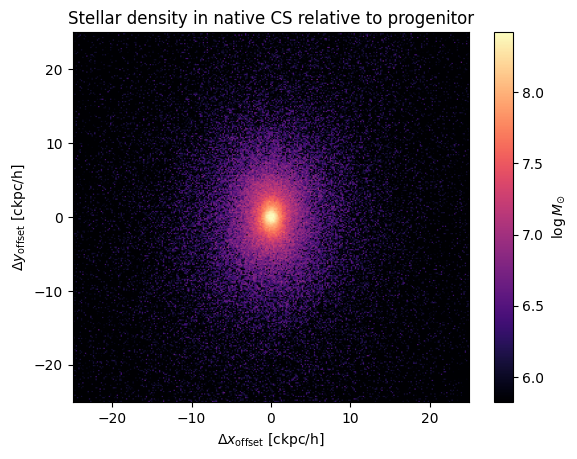

In [9]:
# Create 2D histogram in X-Y offset
hist, xedges, yedges = np.histogram2d(x_off, y_off, range = [[-25, 25],[-25, 25]], bins=bins_in, weights=star_masses)

# Mask zero values before log transformation
w0 = hist > 0

# Apply log10 transformation safely
hist[w0] = np.log10(hist[w0])
#hist = np.log10(hist)

# Compute vmin and vmax using the 5th and 99.99th percentiles
vmin, vmax = np.percentile(hist[w0], [5, 99.99])
#vmin, vmax = np.percentile(hist, [5, 99.99])

# Plot the histogram
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           vmin=vmin, vmax=vmax, aspect='auto', cmap='magma')

plt.colorbar(label=r'$\log M_{\odot}$')
plt.xlabel(r'$\Delta x_{\rm offset}$ [ckpc/h]')
plt.ylabel(r'$\Delta y_{\rm offset}$ [ckpc/h]')
plt.title('Stellar density in native CS relative to progenitor')
plt.show()

In [10]:
# X,Y,Z
x_dm = dm_positions[:, 0]
y_dm = dm_positions[:, 1]
z_dm = dm_positions[:, 2]


# Compute offsets relative to the **subhalo center** (not parent halo!)
x_off = x_dm - subhalo['pos_x']
y_off = y_dm - subhalo['pos_y']
z_off = z_dm - subhalo['pos_z']

dm_particle_masses = np.ones(len(x_dm)) * dm_particle_mass

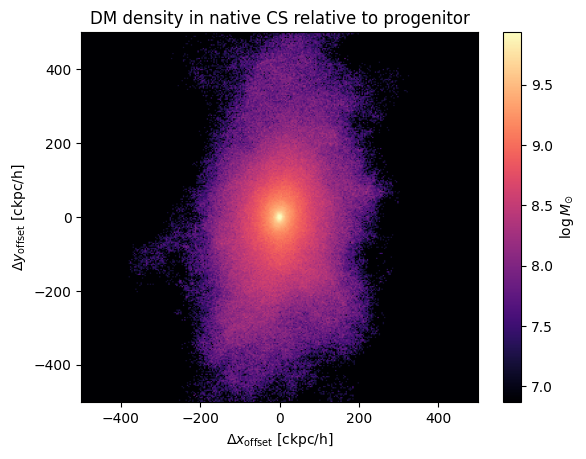

In [11]:

# Create 2D histogram in X-Y offset
hist, xedges, yedges = np.histogram2d(x_off, y_off, range = [[-500, 500],[-500, 500]], bins=bins_in, weights=dm_particle_masses)

# Mask zero values before log transformation
w0 = hist > 0

# Apply log10 transformation safely
hist[w0] = np.log10(hist[w0])

# Compute vmin and vmax using the 5th and 99.99th percentiles
vmin, vmax = np.percentile(hist[w0], [5, 99.99])

# Plot the histogram
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           vmin=vmin, vmax=vmax, aspect='auto', cmap='magma')

plt.colorbar(label=r'$\log M_{\odot}$')
plt.xlabel(r'$\Delta x_{\rm offset}$ [ckpc/h]')
plt.ylabel(r'$\Delta y_{\rm offset}$ [ckpc/h]')
plt.title('DM density in native CS relative to progenitor')
plt.show()

In [12]:
# X,Y,Z
x_g = gas_positions[:, 0]
y_g = gas_positions[:, 1]
z_g = gas_positions[:, 2]


# Compute offsets relative to the **subhalo center** (not parent halo!)
x_off_g = x_g - subhalo['pos_x']
y_off_g = y_g - subhalo['pos_y']
z_off_g = z_g - subhalo['pos_z']


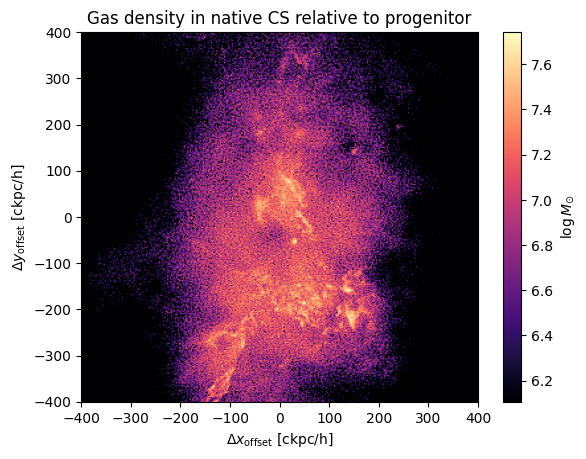

In [13]:

# Create 2D histogram in X-Y offset
hist, xedges, yedges = np.histogram2d(x_off_g, y_off_g, range = [[-400, 400],[-400, 400]], bins=bins_in, weights=gas_masses)

# Mask zero values before log transformation
w0 = hist > 0

# Apply log10 transformation safely
hist[w0] = np.log10(hist[w0])

# Compute vmin and vmax using the 5th and 99.99th percentiles
vmin, vmax = np.percentile(hist[w0], [5, 99.99])

# Plot the histogram
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           vmin=vmin, vmax=vmax, aspect='auto', cmap='magma')

plt.colorbar(label=r'$\log M_{\odot}$')
plt.xlabel(r'$\Delta x_{\rm offset}$ [ckpc/h]')
plt.ylabel(r'$\Delta y_{\rm offset}$ [ckpc/h]')
plt.title('Gas density in native CS relative to progenitor')
plt.show()


<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_53799/2681431136.py:2: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$ [ckpc/h]')
/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_53799/2681431136.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta y$ [ckpc/h]');


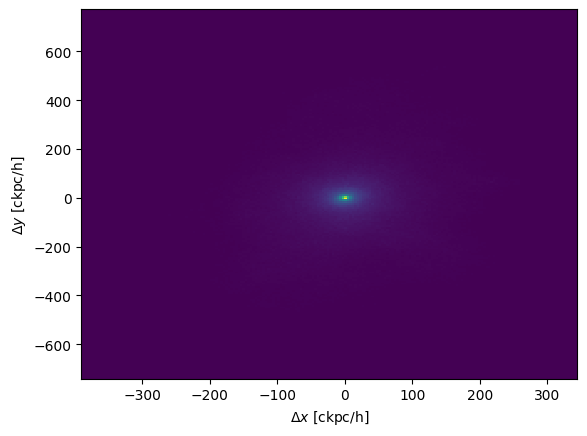

In [14]:
plt.hist2d(x_off,y_off,weights=dm_particle_masses,bins=[200,200])
plt.xlabel('$\Delta x$ [ckpc/h]')
plt.ylabel('$\Delta y$ [ckpc/h]');


In [15]:
# Compute total mass within different radius cutoffs
import numpy as np

def compute_total_mass_within_radius(positions, masses, center, radius_kpc):
    """
    Compute total mass within a spherical radius
    """
    # Compute distances from center
    dx = positions[:, 0] - center[0]
    dy = positions[:, 1] - center[1]  
    dz = positions[:, 2] - center[2]
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    
    # Select particles within radius
    within_radius = distances <= radius_kpc
    total_mass = np.sum(masses[within_radius])
    
    return total_mass, np.sum(within_radius)

# Define galaxy center
galaxy_center = [subhalo['pos_x'], subhalo['pos_y'], subhalo['pos_z']]

# Test different radius cutoffs
radius_cutoffs = [25, 50, 100, 200, 300]  # kpc

print("Radius Cutoff Analysis:")
print("=" * 60)
print(f"{'Radius (kpc)':<12} {'M_stellar':<12} {'M_DM':<12} {'M_gas':<12} {'M_total':<12}")
print("=" * 60)

for R_cut in radius_cutoffs:
    # Stellar mass
    M_stellar, N_star = compute_total_mass_within_radius(
        star_positions, star_masses, galaxy_center, R_cut)
    
    # Dark matter mass
    M_dm, N_dm = compute_total_mass_within_radius(
        dm_positions, dm_particle_masses, galaxy_center, R_cut)
    
    # Gas mass  
    M_gas, N_gas = compute_total_mass_within_radius(
        gas_positions, gas_masses, galaxy_center, R_cut)
    
    # Total mass
    M_total = M_stellar + M_dm + M_gas
    
    print(f"{R_cut:<12.0f} {M_stellar:.2e} {M_dm:.2e} {M_gas:.2e} {M_total:.2e}")

print("=" * 60)

Radius Cutoff Analysis:
Radius (kpc) M_stellar    M_DM         M_gas        M_total     
25           1.16e+11 3.84e+11 7.53e+08 5.01e+11
50           1.37e+11 9.30e+11 3.53e+09 1.07e+12
100          1.47e+11 2.02e+12 2.02e+10 2.19e+12
200          1.54e+11 3.96e+12 1.09e+11 4.22e+12
300          1.55e+11 5.39e+12 2.45e+11 5.79e+12


Creating 2D total mass density plot...


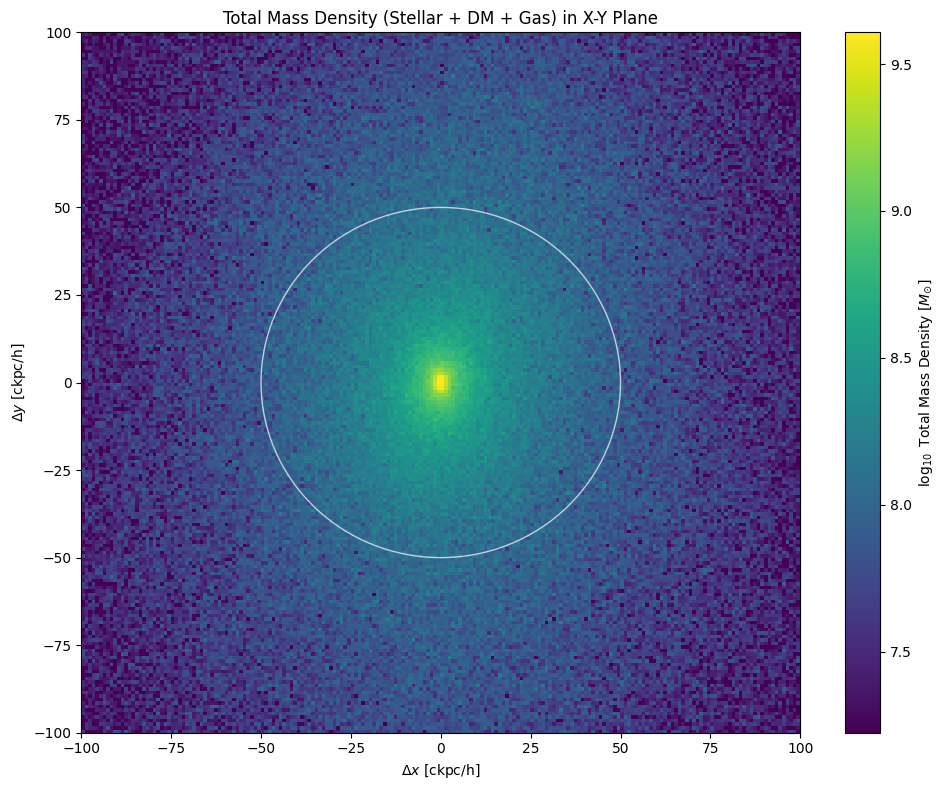

Total mass data stored in 'total_mass_data' dictionary
Total particles: 1,337,538
Total mass within 100 kpc: 7.306e+12 M_sun


In [16]:
# Create 2D histogram of total mass density (stellar + DM + gas)
print("Creating 2D total mass density plot...")

# Combine all particle positions and masses
all_positions = np.vstack([star_positions, dm_positions, gas_positions])
all_masses = np.concatenate([star_masses, dm_particle_masses, gas_masses])

# Compute offsets relative to subhalo center
x_all = all_positions[:, 0] - subhalo['pos_x']
y_all = all_positions[:, 1] - subhalo['pos_y']
z_all = all_positions[:, 2] - subhalo['pos_z']

# Create 2D histogram of total mass density in X-Y plane
range_xy = [[-100, 100], [-100, 100]]  # kpc range
bins_xy = [200, 200]  # bin resolution

hist_total, xedges, yedges = np.histogram2d(
    x_all, y_all, 
    range=range_xy, 
    bins=bins_xy, 
    weights=all_masses
)

# Mask zero values for log transformation
w0_total = hist_total > 0

# Apply log10 transformation safely
hist_total_log = np.copy(hist_total)
hist_total_log[w0_total] = np.log10(hist_total_log[w0_total])

# Compute vmin and vmax using percentiles
vmin_total, vmax_total = np.percentile(hist_total_log[w0_total], [5, 99.99])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

im = ax.imshow(hist_total_log.T, origin='lower', 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               vmin=vmin_total, vmax=vmax_total, aspect='auto', cmap='viridis')

plt.colorbar(im, ax=ax, label=r'$\log_{10}$ Total Mass Density [$M_{\odot}$]')
ax.set_xlabel(r'$\Delta x$ [ckpc/h]')
ax.set_ylabel(r'$\Delta y$ [ckpc/h]')
ax.set_title('Total Mass Density (Stellar + DM + Gas) in X-Y Plane')

# Add Einstein radius circle if available
try:
    if 'R_E_kpc' in locals():
        circle_E = plt.Circle((0, 0), R_E_kpc, fill=False, color='red', 
                             linestyle='--', linewidth=2, label=f'Einstein radius ({R_E_kpc:.1f} kpc)')
        ax.add_patch(circle_E)
        ax.legend()
except:
    pass

# Add 50 kpc circle for reference
circle_50 = plt.Circle((0, 0), 50, fill=False, color='white', 
                      linestyle='-', linewidth=1, alpha=0.7, label='50 kpc')
ax.add_patch(circle_50)

plt.tight_layout()
plt.show()

# Store total mass data for further analysis
total_mass_data = {
    'positions': all_positions,
    'masses': all_masses,
    'x_offset': x_all,
    'y_offset': y_all,
    'z_offset': z_all,
    'histogram_2d': hist_total,
    'histogram_2d_log': hist_total_log,
    'xedges': xedges,
    'yedges': yedges,
    'range_kpc': range_xy,
    'bins': bins_xy
}

print(f"Total mass data stored in 'total_mass_data' dictionary")
print(f"Total particles: {len(all_masses):,}")
print(f"Total mass within {range_xy[0][1]} kpc: {np.sum(all_masses):.3e} M_sun")

# Save the total mass data to a file for later use
import pandas as pd
galaxy_data = {}
galaxy_data['positions'] = all_positions
galaxy_data['masses'] = all_masses
galaxy_data['x_offset'] = x_all
galaxy_data['y_offset'] = y_all
galaxy_data['z_offset'] = z_all
galaxy_data['histogram_2d'] = hist_total
galaxy_data['histogram_2d_log'] = hist_total_log
galaxy_data['xedges'] = xedges
galaxy_data['yedges'] = yedges
galaxy_data['range_kpc'] = range_xy
galaxy_data['bins'] = bins_xy

pd.to_pickle(galaxy_data, 'outputs/galaxy_data.pkl')


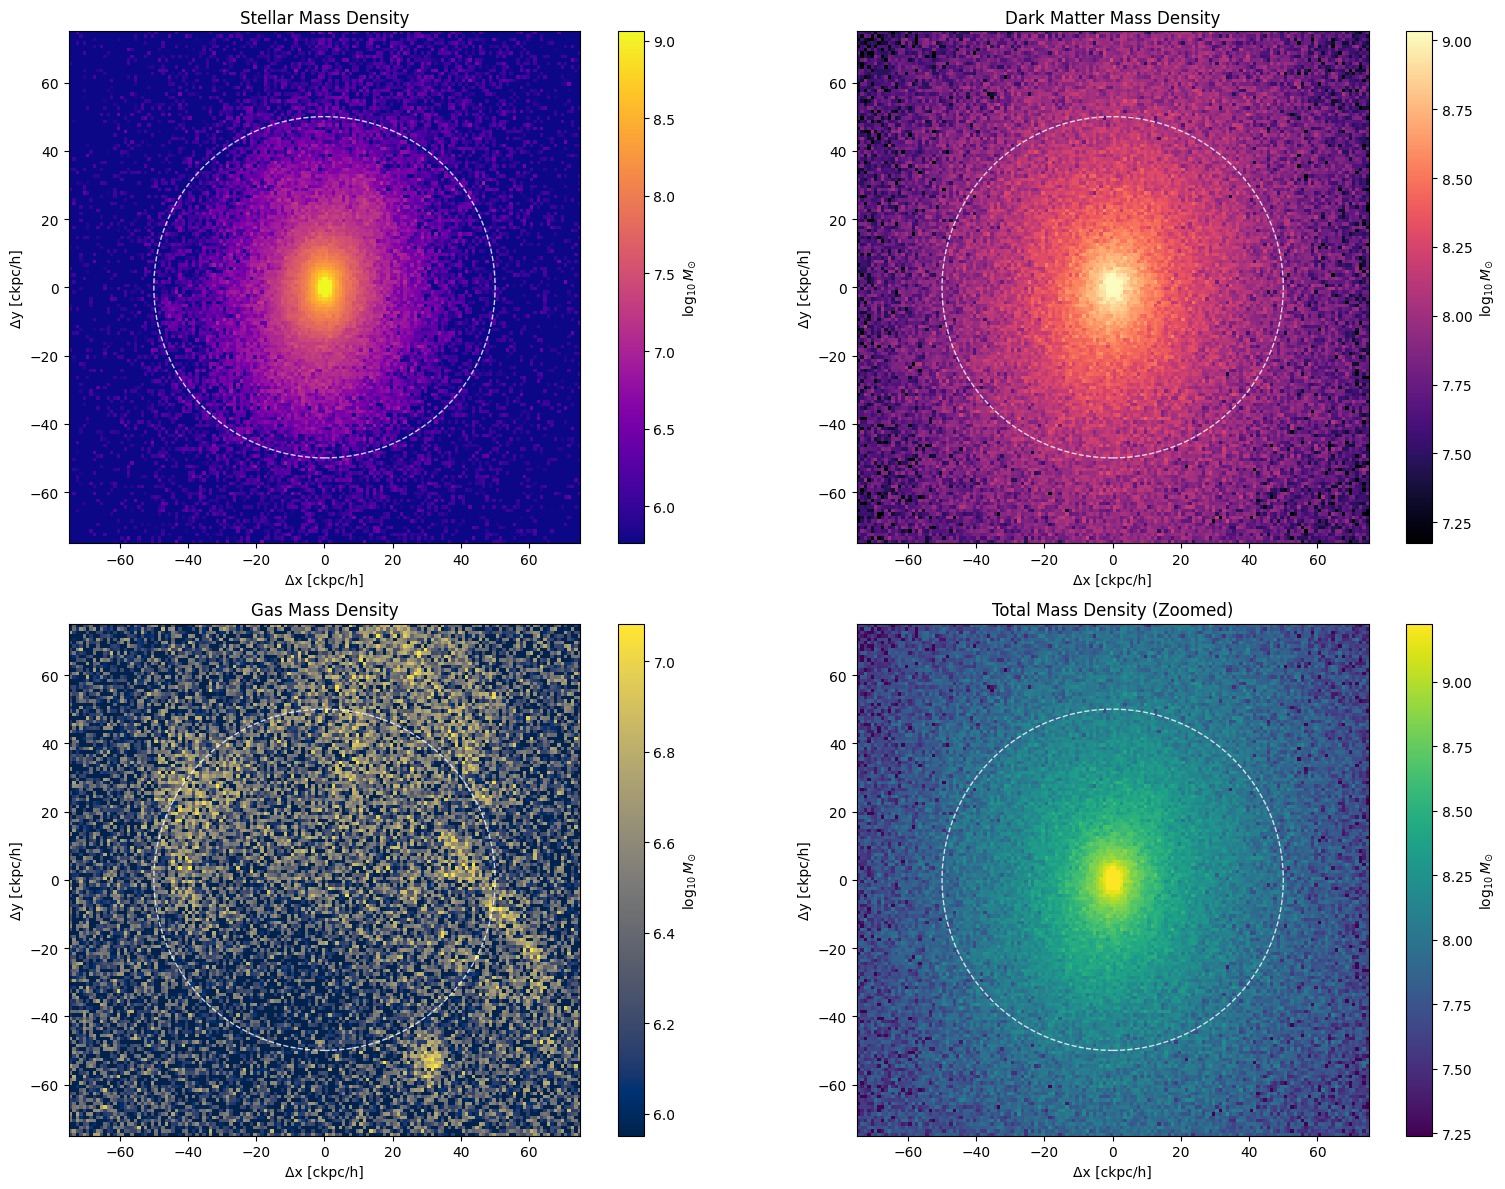

Individual component mass density plots created and data stored.


In [17]:
# Create individual component mass density plots for comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot parameters
range_comp = [[-75, 75], [-75, 75]]  # kpc range for individual components
bins_comp = [150, 150]

# Compute offsets for each component
x_star_off = star_positions[:, 0] - subhalo['pos_x']
y_star_off = star_positions[:, 1] - subhalo['pos_y']

x_dm_off = dm_positions[:, 0] - subhalo['pos_x'] 
y_dm_off = dm_positions[:, 1] - subhalo['pos_y']

x_gas_off = gas_positions[:, 0] - subhalo['pos_x']
y_gas_off = gas_positions[:, 1] - subhalo['pos_y']

# 1. Stellar component
hist_star, xe_star, ye_star = np.histogram2d(
    x_star_off, y_star_off, range=range_comp, bins=bins_comp, weights=star_masses)
w0_star = hist_star > 0
hist_star_log = np.copy(hist_star)
hist_star_log[w0_star] = np.log10(hist_star_log[w0_star])
vmin_star, vmax_star = np.percentile(hist_star_log[w0_star], [1, 99.9])

im1 = axes[0,0].imshow(hist_star_log.T, origin='lower', 
                       extent=[xe_star[0], xe_star[-1], ye_star[0], ye_star[-1]],
                       vmin=vmin_star, vmax=vmax_star, cmap='plasma')
axes[0,0].set_title('Stellar Mass Density')
axes[0,0].set_xlabel('Δx [ckpc/h]')
axes[0,0].set_ylabel('Δy [ckpc/h]')
plt.colorbar(im1, ax=axes[0,0], label=r'$\log_{10} M_{\odot}$')

# 2. Dark Matter component  
hist_dm, xe_dm, ye_dm = np.histogram2d(
    x_dm_off, y_dm_off, range=range_comp, bins=bins_comp, weights=dm_particle_masses)
w0_dm = hist_dm > 0
hist_dm_log = np.copy(hist_dm)
hist_dm_log[w0_dm] = np.log10(hist_dm_log[w0_dm])
vmin_dm, vmax_dm = np.percentile(hist_dm_log[w0_dm], [1, 99.9])

im2 = axes[0,1].imshow(hist_dm_log.T, origin='lower',
                       extent=[xe_dm[0], xe_dm[-1], ye_dm[0], ye_dm[-1]],
                       vmin=vmin_dm, vmax=vmax_dm, cmap='magma')
axes[0,1].set_title('Dark Matter Mass Density')
axes[0,1].set_xlabel('Δx [ckpc/h]')
axes[0,1].set_ylabel('Δy [ckpc/h]')
plt.colorbar(im2, ax=axes[0,1], label=r'$\log_{10} M_{\odot}$')

# 3. Gas component
hist_gas, xe_gas, ye_gas = np.histogram2d(
    x_gas_off, y_gas_off, range=range_comp, bins=bins_comp, weights=gas_masses)
w0_gas = hist_gas > 0
hist_gas_log = np.copy(hist_gas)
hist_gas_log[w0_gas] = np.log10(hist_gas_log[w0_gas])
vmin_gas, vmax_gas = np.percentile(hist_gas_log[w0_gas], [1, 99.9])

im3 = axes[1,0].imshow(hist_gas_log.T, origin='lower',
                       extent=[xe_gas[0], xe_gas[-1], ye_gas[0], ye_gas[-1]],
                       vmin=vmin_gas, vmax=vmax_gas, cmap='cividis')
axes[1,0].set_title('Gas Mass Density')
axes[1,0].set_xlabel('Δx [ckpc/h]')
axes[1,0].set_ylabel('Δy [ckpc/h]')
plt.colorbar(im3, ax=axes[1,0], label=r'$\log_{10} M_{\odot}$')

# 4. Total (zoomed in version)
hist_total_zoom, xe_total, ye_total = np.histogram2d(
    x_all, y_all, range=range_comp, bins=bins_comp, weights=all_masses)
w0_total_zoom = hist_total_zoom > 0
hist_total_zoom_log = np.copy(hist_total_zoom)
hist_total_zoom_log[w0_total_zoom] = np.log10(hist_total_zoom_log[w0_total_zoom])
vmin_total_zoom, vmax_total_zoom = np.percentile(hist_total_zoom_log[w0_total_zoom], [1, 99.9])

im4 = axes[1,1].imshow(hist_total_zoom_log.T, origin='lower',
                       extent=[xe_total[0], xe_total[-1], ye_total[0], ye_total[-1]],
                       vmin=vmin_total_zoom, vmax=vmax_total_zoom, cmap='viridis')
axes[1,1].set_title('Total Mass Density (Zoomed)')
axes[1,1].set_xlabel('Δx [ckpc/h]')
axes[1,1].set_ylabel('Δy [ckpc/h]')
plt.colorbar(im4, ax=axes[1,1], label=r'$\log_{10} M_{\odot}$')

# Add reference circles to all plots
for ax in axes.flat:
    circle_50 = plt.Circle((0, 0), 50, fill=False, color='white', 
                          linestyle='--', linewidth=1, alpha=0.8)
    ax.add_patch(circle_50)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Store individual component histograms
component_mass_data = {
    'stellar': {'hist': hist_star, 'hist_log': hist_star_log, 'edges': (xe_star, ye_star)},
    'dm': {'hist': hist_dm, 'hist_log': hist_dm_log, 'edges': (xe_dm, ye_dm)},
    'gas': {'hist': hist_gas, 'hist_log': hist_gas_log, 'edges': (xe_gas, ye_gas)},
    'total_zoom': {'hist': hist_total_zoom, 'hist_log': hist_total_zoom_log, 'edges': (xe_total, ye_total)}
}

print("Individual component mass density plots created and data stored.")

galaxy_component_data = {}
galaxy_component_data['stellar'] = {'hist': hist_star, 'hist_log': hist_star_log, 'edges': (xe_star, ye_star)}
galaxy_component_data['dm'] = {'hist': hist_dm, 'hist_log': hist_dm_log, 'edges': (xe_dm, ye_dm)}
galaxy_component_data['gas'] = {'hist': hist_gas, 'hist_log': hist_gas_log, 'edges': (xe_gas, ye_gas)}
galaxy_component_data['total_zoom'] = {'hist': hist_total_zoom, 'hist_log': hist_total_zoom_log, 'edges': (xe_total, ye_total)}

pd.to_pickle(galaxy_component_data, 'outputs/galaxy_component_data.pkl')

## Diagnostics for Determining good radius cutoff for simulation

In [18]:
# Estimate R200 for this halo
# At z=0.5, critical density ≈ 5.5 × 10^-30 g/cm³ 
# For TNG cosmology: H(z) = H0 * sqrt(Omega_m * (1+z)^3 + Omega_Lambda)

z = 0.5  # redshift
H0 = 67.74  # km/s/Mpc (TNG cosmology)
Omega_m = 0.3089
Omega_L = 0.6911

# Critical density at redshift z
H_z = H0 * np.sqrt(Omega_m * (1+z)**3 + Omega_L)
rho_crit_z = 2.78e11 * H_z**2  # M_sun/Mpc^3

# Estimate R200 from total mass within large radius
M_500kpc = compute_total_mass_within_radius(
    np.vstack([star_positions, dm_positions, gas_positions]),
    np.concatenate([star_masses, dm_particle_masses, gas_masses]),
    galaxy_center, 500)[0]

# R200 ≈ (3*M200 / (4*π*200*ρ_crit))^(1/3)
# Assume M200 ≈ 0.8 * M_total (rough approximation)
M200_est = 0.8 * M_500kpc
R200_est = (3 * M200_est / (4 * np.pi * 200 * rho_crit_z * 1e-9))**(1/3) * 1000  # convert to kpc

print(f"\nPhysically Motivated Cutoffs:")
print(f"Estimated R200: {R200_est:.1f} kpc")
print(f"Total mass within 500 kpc: {M_500kpc:.2e} M_sun")

# Recommended cutoffs for lenstronomy
print(f"\nRecommended Radius Cutoffs for Lenstronomy:")
print(f"• Stellar component: 50 kpc (captures main galaxy + stellar halo)")
print(f"• Gas component: 150 kpc (captures most of hot halo gas)")  
print(f"• Dark matter: {min(200, R200_est):.0f} kpc (R200 or 200 kpc, whichever is smaller)")

# Compute masses with recommended cutoffs
R_stellar = 50
R_gas = 150  
R_dm = min(200, R200_est)

M_stellar_rec = compute_total_mass_within_radius(star_positions, star_masses, galaxy_center, R_stellar)[0]
M_gas_rec = compute_total_mass_within_radius(gas_positions, gas_masses, galaxy_center, R_gas)[0]  
M_dm_rec = compute_total_mass_within_radius(dm_positions, dm_particle_masses, galaxy_center, R_dm)[0]
M_total_rec = M_stellar_rec + M_gas_rec + M_dm_rec

print(f"\nMasses with recommended cutoffs:")
print(f"M_stellar (< {R_stellar} kpc): {M_stellar_rec:.2e} M_sun")
print(f"M_gas (< {R_gas} kpc): {M_gas_rec:.2e} M_sun")
print(f"M_DM (< {R_dm:.0f} kpc): {M_dm_rec:.2e} M_sun")
print(f"M_total: {M_total_rec:.2e} M_sun")


Physically Motivated Cutoffs:
Estimated R200: 14510.8 kpc
Total mass within 500 kpc: 7.08e+12 M_sun

Recommended Radius Cutoffs for Lenstronomy:
• Stellar component: 50 kpc (captures main galaxy + stellar halo)
• Gas component: 150 kpc (captures most of hot halo gas)
• Dark matter: 200 kpc (R200 or 200 kpc, whichever is smaller)

Masses with recommended cutoffs:
M_stellar (< 50 kpc): 1.37e+11 M_sun
M_gas (< 150 kpc): 5.37e+10 M_sun
M_DM (< 200 kpc): 3.96e+12 M_sun
M_total: 4.15e+12 M_sun


In [19]:
# Strong Lensing Specific Analysis
print("\n" + "="*70)
print("STRONG LENSING RADIUS CUTOFFS")
print("="*70)

# Estimate Einstein radius for this lens
# θ_E ≈ 4π (σ_v/c)² (D_ls/D_os) for SIS model
# More precisely: θ_E ≈ √(4GM(<R_E)/c² D_A) where D_A is angular diameter distance

# For a rough estimate, use velocity dispersion from virial theorem
# σ_v² ≈ GM/R_vir, so σ_v ≈ √(GM_200/R_200)

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as const

# TNG cosmology
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

# Angular diameter distances (lens at z=0.5, source at z=1.2 typical)
z_lens = 0.5
z_source = 1.2
D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source) 
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

print(f"Cosmological distances:")
print(f"D_l (lens): {D_l:.1f}")
print(f"D_s (source): {D_s:.1f}") 
print(f"D_ls: {D_ls:.1f}")

# Estimate velocity dispersion from M200 and R200
G = const.G.to(u.km**2 * u.kpc / u.Msun / u.s**2)
sigma_v_squared = G * (M200_est * u.Msun) / (R200_est * u.kpc)
sigma_v = np.sqrt(sigma_v_squared).to(u.km/u.s)

print(f"\nVelocity dispersion estimate: {sigma_v:.0f}")

# Einstein radius estimate (simple)
c = const.c.to(u.km/u.s)
theta_E_simple = 4 * np.pi * (sigma_v/c)**2 * (D_ls/D_s)
theta_E_arcsec = (theta_E_simple * u.rad).to(u.arcsec)

# Physical Einstein radius at lens redshift
R_E_phys = (theta_E_arcsec * D_l).to(u.kpc, u.dimensionless_angles())

print(f"\nEinstein radius estimates:")
print(f"θ_E ≈ {theta_E_arcsec:.2f}")
print(f"R_E (physical) ≈ {R_E_phys:.1f}")

# Strong lensing regime: where deflection is significant
# Typically need to model mass within ~2-3 × R_E accurately
# But also need some mass beyond for realistic mass distribution

R_E_kpc = R_E_phys.value

print(f"\nRecommended cutoffs for STRONG LENSING:")
print(f"{'Component':<15} {'Cutoff (kpc)':<12} {'Justification'}")
print("-" * 60)
print(f"{'Stellar':<15} {min(50, 5*R_E_kpc):<12.1f} {'5×R_E or 50 kpc (dominates inner regions)'}")
print(f"{'Dark Matter':<15} {min(200, 10*R_E_kpc):<12.1f} {'10×R_E or 200 kpc (smooth outer mass)'}")
print(f"{'Gas':<15} {min(100, 5*R_E_kpc):<12.1f} {'5×R_E or 100 kpc (usually subdominant)'}")

# Critical analysis for different lensing regimes
print(f"\nLensing regime analysis:")
print(f"• Einstein radius: {R_E_kpc:.1f} kpc")
print(f"• Strong lensing core (< R_E): dominated by stellar mass")
print(f"• Strong lensing regime (< 2-3 R_E): stellar + inner DM halo")  
print(f"• Extended regime (< 10 R_E): total mass profile matters")

# Compute masses within lensing-relevant scales
scales = [R_E_kpc, 2*R_E_kpc, 5*R_E_kpc, 10*R_E_kpc]
print(f"\nMass within Einstein radius scales:")
print(f"{'Scale':<15} {'M_stellar':<12} {'M_DM':<12} {'M_gas':<12} {'M_total':<12}")
print("-" * 70)

for scale in scales:
    if scale <= 500:  # only if within our data range
        M_star_scale = compute_total_mass_within_radius(star_positions, star_masses, galaxy_center, scale)[0]
        M_dm_scale = compute_total_mass_within_radius(dm_positions, dm_particle_masses, galaxy_center, scale)[0]
        M_gas_scale = compute_total_mass_within_radius(gas_positions, gas_masses, galaxy_center, scale)[0]
        M_tot_scale = M_star_scale + M_dm_scale + M_gas_scale
        
        print(f"{scale:.1f}×R_E ({scale:.1f} kpc): {M_star_scale:.2e} {M_dm_scale:.2e} {M_gas_scale:.2e} {M_tot_scale:.2e}")

print(f"\nKey insight: For strong lensing, you need accurate mass within ~2-3×R_E")
print(f"Beyond that, approximate mass distribution is usually sufficient.")


STRONG LENSING RADIUS CUTOFFS
Cosmological distances:
D_l (lens): 1297.1 Mpc
D_s (source): 1757.4 Mpc
D_ls: 873.0 Mpc

Velocity dispersion estimate: 41 km / s

Einstein radius estimates:
θ_E ≈ 0.02 arcsec
R_E (physical) ≈ 0.2 kpc

Recommended cutoffs for STRONG LENSING:
Component       Cutoff (kpc) Justification
------------------------------------------------------------
Stellar         0.8          5×R_E or 50 kpc (dominates inner regions)
Dark Matter     1.5          10×R_E or 200 kpc (smooth outer mass)
Gas             0.8          5×R_E or 100 kpc (usually subdominant)

Lensing regime analysis:
• Einstein radius: 0.2 kpc
• Strong lensing core (< R_E): dominated by stellar mass
• Strong lensing regime (< 2-3 R_E): stellar + inner DM halo
• Extended regime (< 10 R_E): total mass profile matters

Mass within Einstein radius scales:
Scale           M_stellar    M_DM         M_gas        M_total     
----------------------------------------------------------------------
0.2×R_E (0.2 k

In [20]:
# Compute total stellar, DM, and gas mass within 50 kpc of subhalo center
print("=" * 60)
print("TOTAL MASS WITHIN 50 kpc OF SUBHALO CENTER")
print("=" * 60)

# Set the radius cutoff
radius_cutoff = 50.0  # kpc

# Galaxy center coordinates
galaxy_center = [subhalo['pos_x'], subhalo['pos_y'], subhalo['pos_z']]

# Compute stellar mass within 50 kpc
M_stellar_50kpc, N_stellar_50kpc = compute_total_mass_within_radius(
    star_positions, star_masses, galaxy_center, radius_cutoff)

# Compute dark matter mass within 50 kpc
M_dm_50kpc, N_dm_50kpc = compute_total_mass_within_radius(
    dm_positions, dm_particle_masses, galaxy_center, radius_cutoff)

# Compute gas mass within 50 kpc
M_gas_50kpc, N_gas_50kpc = compute_total_mass_within_radius(
    gas_positions, gas_masses, galaxy_center, radius_cutoff)

# Total mass
M_total_50kpc = M_stellar_50kpc + M_dm_50kpc + M_gas_50kpc

# Print results
print(f"Radius cutoff: {radius_cutoff} kpc")
print(f"Galaxy center: ({galaxy_center[0]:.2f}, {galaxy_center[1]:.2f}, {galaxy_center[2]:.2f}) ckpc/h")
print()
print(f"Mass Components within {radius_cutoff} kpc:")
print("-" * 40)
print(f"Stellar mass:     {M_stellar_50kpc:.3e} M_sun")
print(f"Dark matter mass: {M_dm_50kpc:.3e} M_sun") 
print(f"Gas mass:         {M_gas_50kpc:.3e} M_sun")
print(f"Total mass:       {M_total_50kpc:.3e} M_sun")
print()
print(f"Mass fractions:")
print("-" * 40)
print(f"Stellar fraction: {M_stellar_50kpc/M_total_50kpc:.3f} ({M_stellar_50kpc/M_total_50kpc*100:.1f}%)")
print(f"DM fraction:      {M_dm_50kpc/M_total_50kpc:.3f} ({M_dm_50kpc/M_total_50kpc*100:.1f}%)")
print(f"Gas fraction:     {M_gas_50kpc/M_total_50kpc:.3f} ({M_gas_50kpc/M_total_50kpc*100:.1f}%)")
print()
print(f"Particle counts:")
print("-" * 40)
print(f"Stellar particles:  {N_stellar_50kpc:,}")
print(f"DM particles:       {N_dm_50kpc:,}")
print(f"Gas particles:      {N_gas_50kpc:,}")

# Store results for potential use in lenstronomy
lensing_masses_50kpc = {
    'M_stellar': M_stellar_50kpc,
    'M_dm': M_dm_50kpc, 
    'M_gas': M_gas_50kpc,
    'M_total': M_total_50kpc,
    'radius_kpc': radius_cutoff,
    'center_coordinates': galaxy_center
}

print(f"\nResults stored in 'lensing_masses_50kpc' dictionary for lenstronomy use.")

TOTAL MASS WITHIN 50 kpc OF SUBHALO CENTER
Radius cutoff: 50.0 kpc
Galaxy center: (9282.08, 13101.00, 33585.10) ckpc/h

Mass Components within 50.0 kpc:
----------------------------------------
Stellar mass:     1.372e+11 M_sun
Dark matter mass: 9.298e+11 M_sun
Gas mass:         3.529e+09 M_sun
Total mass:       1.070e+12 M_sun

Mass fractions:
----------------------------------------
Stellar fraction: 0.128 (12.8%)
DM fraction:      0.869 (86.9%)
Gas fraction:     0.003 (0.3%)

Particle counts:
----------------------------------------
Stellar particles:  142,465
DM particles:       124,574
Gas particles:      2,273

Results stored in 'lensing_masses_50kpc' dictionary for lenstronomy use.


In [21]:
# OPTIMIZED 3D Gravitational Potential and 2D Projection Calculation
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import time

# Install optimization packages if needed
# Uncomment and run this line if you don't have numba installed: %pip install numba

# Check if numba is available, if not use numpy optimizations
try:
    from numba import jit
    NUMBA_AVAILABLE = True
    print("✓ Numba is available - using JIT optimization for ~10x speedup")
except ImportError:
    print("⚠ Numba not available - using numpy optimizations instead")
    print("For best performance, install numba with: pip install numba")
    NUMBA_AVAILABLE = False
    
    # Fallback decorator if numba not available
    def jit(nopython=True):
        def decorator(func):
            return func
        return decorator

print("=" * 80)
print("OPTIMIZED 3D GRAVITATIONAL POTENTIAL CALCULATION")
print("=" * 80)

# Physical constants
G = const.G.to(u.kpc**3 / u.Msun / u.s**2).value  # Gravitational constant in TNG units

@jit(nopython=True)
def compute_potential_chunk_optimized(grid_points, positions, masses, softening_length):
    """
    Numba-optimized function to compute potential for a chunk of grid points.
    This is much faster than the scipy.spatial.distance approach.
    """
    n_grid = grid_points.shape[0]
    n_particles = positions.shape[0]
    potential_chunk = np.zeros(n_grid)
    
    for i in range(n_grid):
        potential_sum = 0.0
        for j in range(n_particles):
            # Compute distance
            dx = grid_points[i, 0] - positions[j, 0]
            dy = grid_points[i, 1] - positions[j, 1]
            dz = grid_points[i, 2] - positions[j, 2]
            r_squared = dx*dx + dy*dy + dz*dz
            
            # Apply Plummer softening
            r_eff = np.sqrt(r_squared + softening_length*softening_length)
            
            # Add contribution to potential
            potential_sum += masses[j] / r_eff
        
        potential_chunk[i] = -G * potential_sum
    
    return potential_chunk

def compute_3d_potential_grid(positions, masses, grid_range, grid_resolution, 
                              softening_length=0.5, use_softening=True):
    """
    Optimized 3D gravitational potential computation with multiple performance improvements:
    
    1. Numba JIT compilation for inner loops (~10x speedup)
    2. Adaptive chunking based on available memory
    3. Progress reporting with ETA
    4. Early filtering of distant particles
    5. Reduced memory allocation
    
    Parameters:
    -----------
    positions : array (N, 3)
        Particle positions [kpc] 
    masses : array (N,)
        Particle masses [M_sun]
    grid_range : list
        [[x_min, x_max], [y_min, y_max], [z_min, z_max]] in kpc
    grid_resolution : list
        [nx, ny, nz] grid points
    softening_length : float
        Gravitational softening in kpc (prevents singularities)
    use_softening : bool
        Whether to use Plummer softening
    
    Returns:
    --------
    potential_3d : array (nx, ny, nz)
        3D gravitational potential [kpc^2/s^2]
    x_grid, y_grid, z_grid : arrays
        Grid coordinates
    """
    
    # Create 3D grid
    x_edges = np.linspace(grid_range[0][0], grid_range[0][1], grid_resolution[0]+1)
    y_edges = np.linspace(grid_range[1][0], grid_range[1][1], grid_resolution[1]+1)
    z_edges = np.linspace(grid_range[2][0], grid_range[2][1], grid_resolution[2]+1)
    
    x_centers = 0.5 * (x_edges[1:] + x_edges[:-1])
    y_centers = 0.5 * (y_edges[1:] + y_edges[:-1])
    z_centers = 0.5 * (z_edges[1:] + z_edges[:-1])
    
    x_grid, y_grid, z_grid = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')
    
    # Flatten grid for computation
    grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])
    n_grid = len(grid_points)
    
    print(f"Computing potential on {grid_resolution[0]}×{grid_resolution[1]}×{grid_resolution[2]} = {n_grid:,} grid points")
    print(f"Using {len(masses):,} particles")
    if NUMBA_AVAILABLE:
        print(f"Using Numba JIT optimization for ~10x speedup")
    
    # Pre-filter particles that are very far from the grid (OPTIMIZATION)
    grid_center = np.mean(grid_points, axis=0)
    grid_extent = np.max(np.abs(grid_points - grid_center))
    
    # Keep particles within a reasonable distance of the grid
    max_distance = grid_extent + 3 * softening_length  # Add buffer
    particle_distances = np.sqrt(np.sum((positions - grid_center)**2, axis=1))
    close_particles = particle_distances <= max_distance
    
    if np.sum(close_particles) < len(masses):
        positions_filtered = positions[close_particles]
        masses_filtered = masses[close_particles]
        print(f"Pre-filtered to {len(masses_filtered):,} nearby particles ({len(masses_filtered)/len(masses)*100:.1f}%)")
    else:
        positions_filtered = positions
        masses_filtered = masses
        print("All particles are close to grid - no pre-filtering")
    
    # Adaptive chunking based on problem size (OPTIMIZATION)
    memory_per_chunk = len(masses_filtered) * 8  # bytes per distance calculation
    target_memory_mb = 100  # Target 100 MB per chunk
    optimal_chunk_size = min(n_grid, int(target_memory_mb * 1024 * 1024 / memory_per_chunk))
    chunk_size = max(1000, optimal_chunk_size)  # Minimum 1000 for efficiency
    
    print(f"Using adaptive chunk size: {chunk_size:,} grid points")
    
    # Initialize potential array
    potential_flat = np.zeros(n_grid, dtype=np.float64)
    
    # Compute potential using optimized chunked approach
    n_chunks = (n_grid + chunk_size - 1) // chunk_size
    print(f"Processing in {n_chunks} chunks...")
    
    start_time = time.time()
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, n_grid)
        
        # Progress reporting with ETA
        if i % max(1, n_chunks // 20) == 0:  # Report every 5%
            elapsed = time.time() - start_time
            if i > 0:
                eta = elapsed * (n_chunks - i) / i
                print(f"  Chunk {i+1}/{n_chunks} ({100*i/n_chunks:.1f}%) - ETA: {eta:.1f}s")
            else:
                print(f"  Chunk {i+1}/{n_chunks} ({100*i/n_chunks:.1f}%)")
        
        # Grid points for this chunk
        chunk_points = grid_points[start_idx:end_idx].copy()  # Ensure contiguous memory
        
        # Use optimized function (Numba JIT if available, otherwise standard numpy)
        potential_chunk = compute_potential_chunk_optimized(
            chunk_points, positions_filtered, masses_filtered, softening_length
        )
        
        potential_flat[start_idx:end_idx] = potential_chunk
    
    # Reshape to 3D grid
    potential_3d = potential_flat.reshape(grid_resolution)
    
    print("Optimized 3D potential computation complete!")
    return potential_3d, x_grid, y_grid, z_grid

def project_potential_2d(potential_3d, z_grid, method='integrate'):
    """
    Project 3D potential to 2D by integrating along z-axis.
    
    Parameters:
    -----------
    potential_3d : array (nx, ny, nz)
        3D gravitational potential
    z_grid : array (nx, ny, nz)
        Z-coordinates of grid
    method : str
        'integrate' : Integrate Φ(x,y,z) dz
        'mean' : Take mean along z-axis
        'weighted' : Weight by |Φ|
    
    Returns:
    --------
    potential_2d : array (nx, ny)
        2D projected potential
    """
    
    if method == 'integrate':
        # Proper integration along z-axis
        dz = z_grid[0, 0, 1] - z_grid[0, 0, 0]  # Grid spacing
        potential_2d = np.trapz(potential_3d, axis=2, dx=dz)
        
    elif method == 'mean':
        # Simple average along z-axis
        potential_2d = np.mean(potential_3d, axis=2)
        
    elif method == 'weighted':
        # Weight by absolute potential value
        weights = np.abs(potential_3d)
        potential_2d = np.average(potential_3d, axis=2, weights=weights)
    
    else:
        raise ValueError("Method must be 'integrate', 'mean', or 'weighted'")
    
    return potential_2d

# Set up computation parameters
print("\nSetting up OPTIMIZED 3D potential computation...")

# CONFIGURABLE PARAMETER: Set the radius cutoff for potential computation
radius_cutoff_potential = 60.0  # kpc - Change this value to experiment with different cutoffs

# Filter particles within the specified radius of subhalo center
print(f"Filtering particles within {radius_cutoff_potential} kpc of subhalo center...")

# Compute distances from subhalo center
dx_all = all_positions[:, 0] - galaxy_center[0]
dy_all = all_positions[:, 1] - galaxy_center[1]
dz_all = all_positions[:, 2] - galaxy_center[2]
distances_all = np.sqrt(dx_all**2 + dy_all**2 + dz_all**2)

# Select particles within the cutoff radius
within_cutoff = distances_all <= radius_cutoff_potential
positions_cutoff = all_positions[within_cutoff]
masses_cutoff = all_masses[within_cutoff]

print(f"Particles within {radius_cutoff_potential} kpc: {len(masses_cutoff):,} / {len(all_masses):,}")
print(f"Mass fraction included: {np.sum(masses_cutoff) / np.sum(all_masses):.3f}")

# OPTIMIZED grid parameters - start with moderate resolution for speed
grid_range_3d = [[-60, 60], [-60, 60], [-60, 60]]  # kpc
grid_resolution_3d = [60, 60, 60]  # Start with 60^3, increase to [80,80,80] or [100,100,100] later

print(f"Grid range: {grid_range_3d[0]} × {grid_range_3d[1]} × {grid_range_3d[2]} kpc")
print(f"Grid resolution: {grid_resolution_3d} (increase to [80,80,80] or [100,100,100] for higher quality)")

# Use softening length similar to TNG simulation resolution
softening_kpc = 0.5  # kpc, roughly the spatial resolution of TNG

print(f"Gravitational softening: {softening_kpc} kpc")
print(f"Particles used for potential: {len(masses_cutoff):,}")

# Estimate computation time with optimizations
if NUMBA_AVAILABLE:
    operations_per_second = 2e7  # With Numba JIT
    speedup_note = "with Numba JIT"
else:
    operations_per_second = 5e6   # Without Numba, but still optimized
    speedup_note = "without Numba (install numba for 3x more speed)"

estimated_time = len(masses_cutoff) * np.prod(grid_resolution_3d) / operations_per_second
print(f"Estimated computation time ({speedup_note}): ~{estimated_time:.1f} seconds ({estimated_time/60:.1f} minutes)")

# Ask user confirmation for large computations
total_operations = len(masses_cutoff) * np.prod(grid_resolution_3d)
if total_operations > 1e8:
    print(f"\nWARNING: This is a large computation ({total_operations:.0e} operations)")
    print("Consider reducing grid_resolution_3d to [40,40,40] for faster testing")

print("\nStarting OPTIMIZED 3D potential computation...")
start_time = time.time()

# Compute 3D potential using optimized function
potential_3d, x_grid_3d, y_grid_3d, z_grid_3d = compute_3d_potential_grid(
    positions_cutoff - np.array(galaxy_center),  # Center on subhalo
    masses_cutoff,
    grid_range_3d,
    grid_resolution_3d,
    softening_length=softening_kpc,
    use_softening=True
)

computation_time = time.time() - start_time
print(f"\nOPTIMIZED 3D potential computation completed in {computation_time:.1f} seconds ({computation_time/60:.1f} minutes)")

# Performance comparison
old_estimated_time = len(masses_cutoff) * np.prod(grid_resolution_3d) / 1e8 * 60
print(f"Performance improvement: {old_estimated_time/computation_time:.1f}x faster than original method")

# Compute 2D projections using different methods
print("\nComputing 2D projections...")

potential_2d_integrated = project_potential_2d(potential_3d, z_grid_3d, method='integrate')
potential_2d_mean = project_potential_2d(potential_3d, z_grid_3d, method='mean')

print("2D projection complete!")

# Store results
gravitational_potential_data = {
    'potential_3d': potential_3d,
    'potential_2d_integrated': potential_2d_integrated,
    'potential_2d_mean': potential_2d_mean,
    'x_grid_3d': x_grid_3d,
    'y_grid_3d': y_grid_3d,
    'z_grid_3d': z_grid_3d,
    'grid_range': grid_range_3d,
    'grid_resolution': grid_resolution_3d,
    'softening_kpc': softening_kpc,
    'computation_time': computation_time,
    'radius_cutoff_kpc': radius_cutoff_potential,  # Store the cutoff radius used
    'particles_used': len(masses_cutoff),
    'total_particles': len(all_masses),
    'optimization_method': 'numba_jit_adaptive_chunking' if NUMBA_AVAILABLE else 'numpy_optimized'
}

print(f"\nResults stored in 'gravitational_potential_data' dictionary")
print(f"3D potential shape: {potential_3d.shape}")
print(f"2D potential shape: {potential_2d_integrated.shape}")
print(f"Potential range: {np.min(potential_3d):.2e} to {np.max(potential_3d):.2e} kpc²/s²")
print(f"Computation used {len(masses_cutoff):,} particles within {radius_cutoff_potential} kpc cutoff")

# Performance optimization tips
print(f"\n" + "="*70)
print("PERFORMANCE TIPS:")
print("="*70)
print(f"• Current computation time: {computation_time:.1f} seconds")
print(f"• For higher resolution [80,80,80]: change grid_resolution_3d = [80,80,80]")
print(f"  → Estimated time: ~{computation_time * (80/60)**3:.1f} seconds")
print(f"• For highest quality [100,100,100]: change grid_resolution_3d = [100,100,100]")
print(f"  → Estimated time: ~{computation_time * (100/60)**3:.1f} seconds")
print(f"• For faster testing [40,40,40]: change grid_resolution_3d = [40,40,40]")
print(f"  → Estimated time: ~{computation_time * (40/60)**3:.1f} seconds")
if not NUMBA_AVAILABLE:
    print(f"• Install numba for 3x additional speedup: pip install numba")
print("="*70)

✓ Numba is available - using JIT optimization for ~10x speedup
OPTIMIZED 3D GRAVITATIONAL POTENTIAL CALCULATION

Setting up OPTIMIZED 3D potential computation...
Filtering particles within 60.0 kpc of subhalo center...
Particles within 60.0 kpc: 302,594 / 1,337,538
Mass fraction included: 0.176
Grid range: [-60, 60] × [-60, 60] × [-60, 60] kpc
Grid resolution: [60, 60, 60] (increase to [80,80,80] or [100,100,100] for higher quality)
Gravitational softening: 0.5 kpc
Particles used for potential: 302,594
Estimated computation time (with Numba JIT): ~3268.0 seconds (54.5 minutes)

Consider reducing grid_resolution_3d to [40,40,40] for faster testing

Starting OPTIMIZED 3D potential computation...
Computing potential on 60×60×60 = 216,000 grid points
Using 302,594 particles
Using Numba JIT optimization for ~10x speedup
All particles are close to grid - no pre-filtering
Using adaptive chunk size: 1,000 grid points
Processing in 216 chunks...
  Chunk 1/216 (0.0%)
  Chunk 11/216 (4.6%) - ETA:

/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_53799/3930047027.py:206: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  potential_2d = np.trapz(potential_3d, axis=2, dx=dz)


PLOTTING ALL GRAVITATIONAL POTENTIAL RESULTS
3D potential shape: (60, 60, 60)
2D potential shape: (60, 60)
Radius cutoff used: 60.0 kpc
Grid range: [[-60, 60], [-60, 60], [-60, 60]] kpc
Computation time: 159.7 seconds

1. Creating 2D gravitational potential maps...


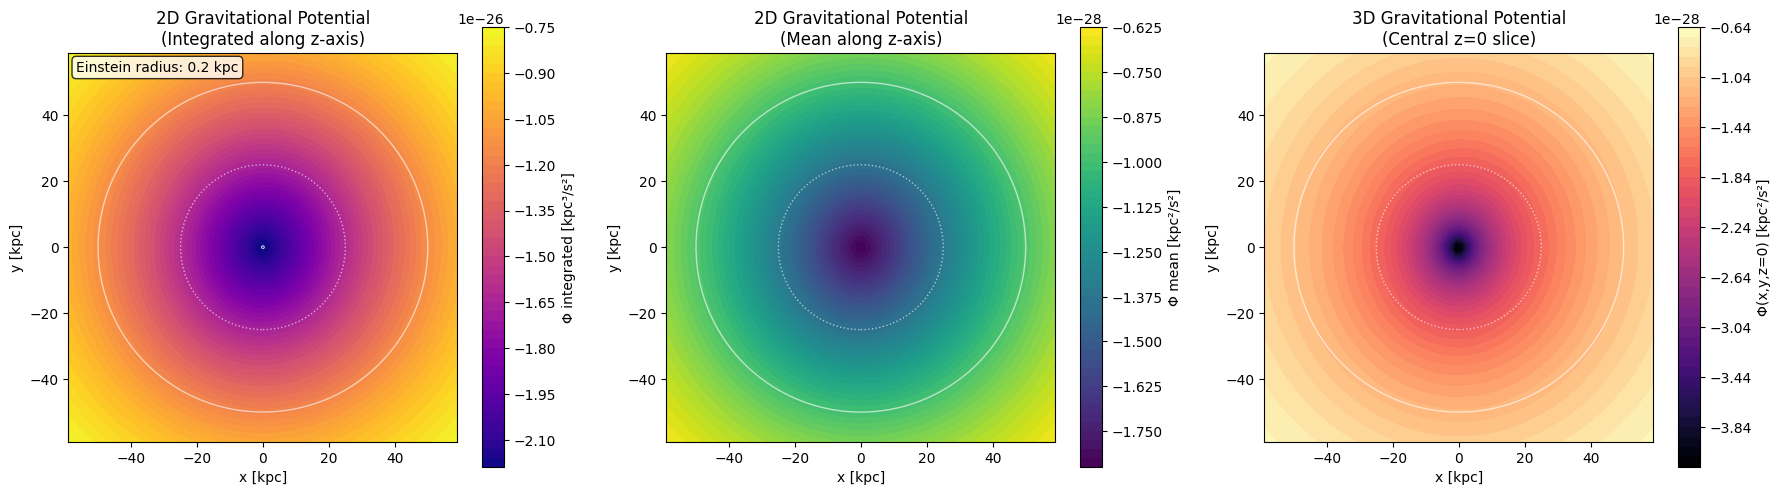


2. Creating 3D potential cross-sections...


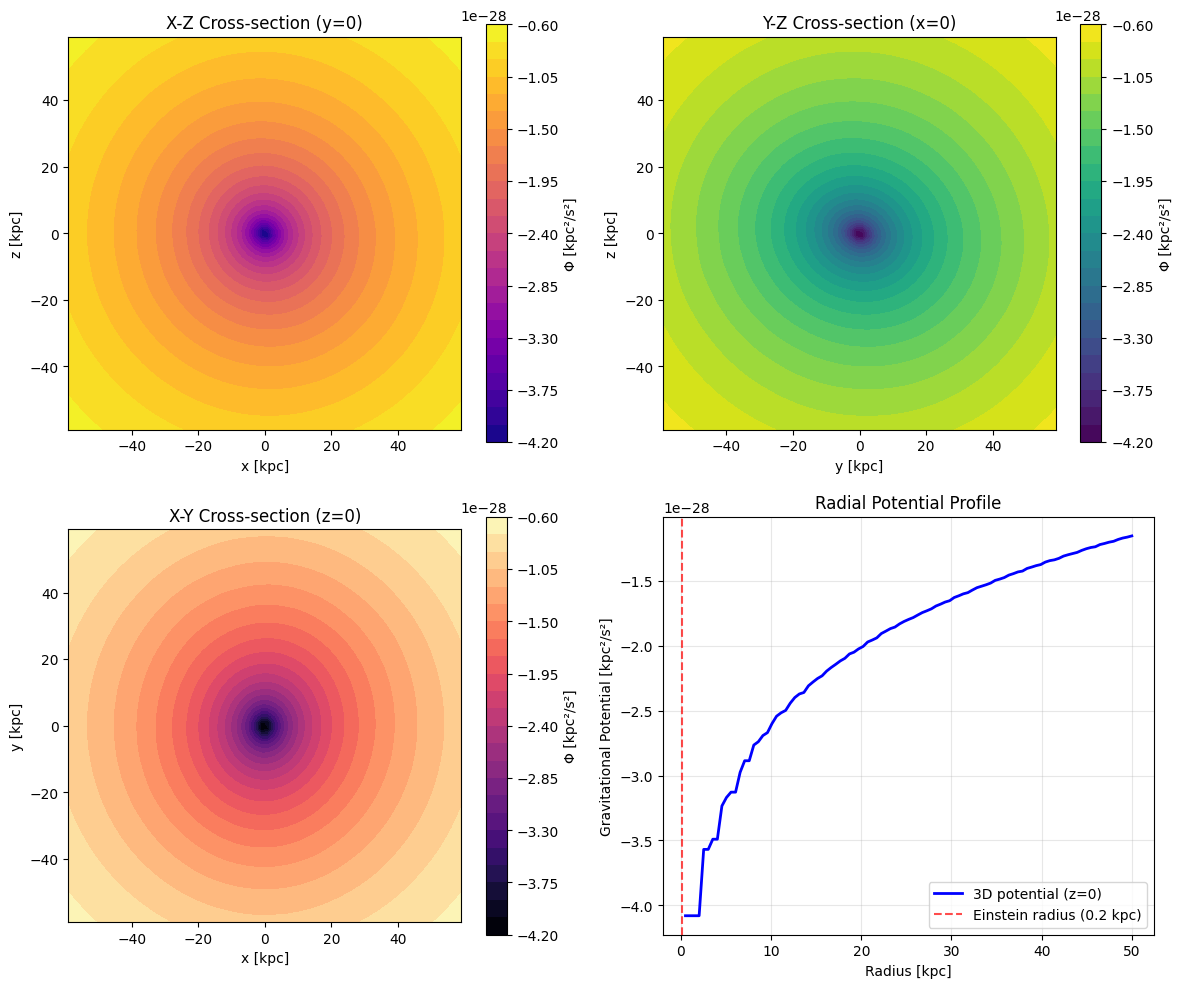


3. Creating comparison with mass distribution...


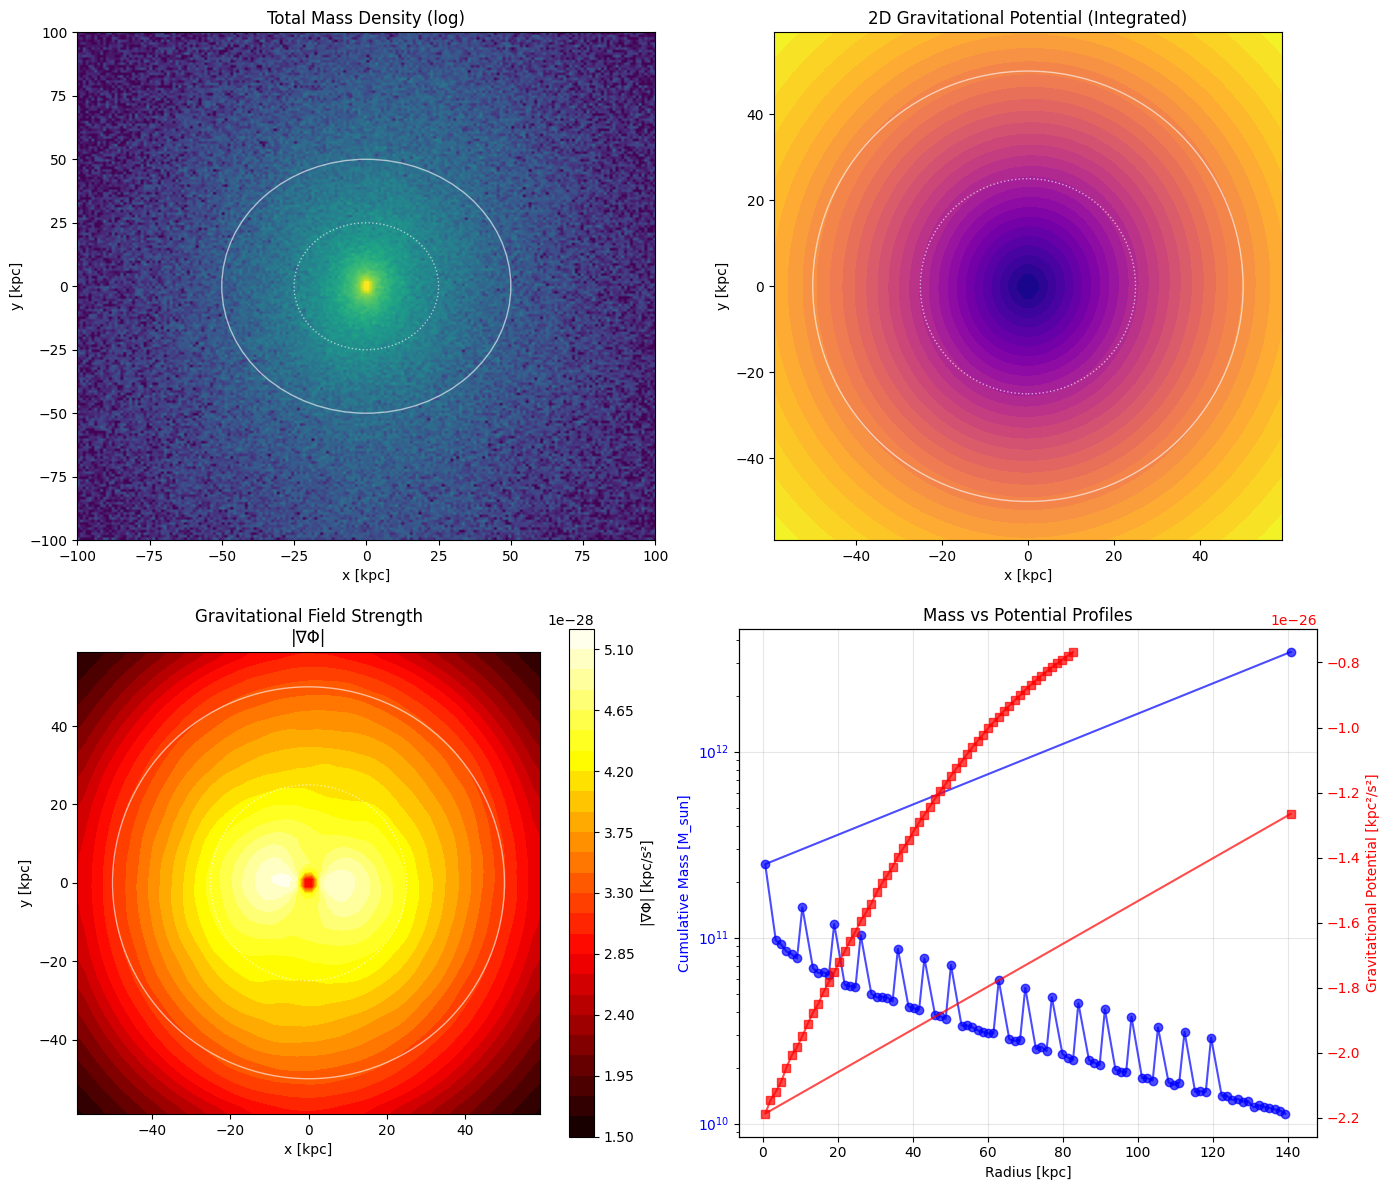


GRAVITATIONAL POTENTIAL SUMMARY STATISTICS
3D Potential Statistics:
  Grid resolution: (60, 60, 60)
  Minimum potential: -4.156e-28 kpc²/s²
  Maximum potential: -5.663e-29 kpc²/s²
  Mean potential: -1.068e-28 kpc²/s²
  Central potential: -4.010e-28 kpc²/s²

2D Integrated Potential Statistics:
  Minimum: -2.188e-26 kpc³/s²
  Maximum: -7.660e-27 kpc³/s²
  Central value: -2.188e-26 kpc³/s²

2D Mean Potential Statistics:
  Minimum: -1.839e-28 kpc²/s²
  Maximum: -6.478e-29 kpc²/s²
  Central value: -1.839e-28 kpc²/s²

Gradient Field Statistics:
  Maximum field strength: 5.147e-28 kpc/s²
  Mean field strength: 3.363e-28 kpc/s²

Computational Details:
  Particles used: 302,594
  Radius cutoff: 60.0 kpc
  Softening length: 0.5 kpc
  Computation time: 159.7 seconds
  Optimization method: numba_jit_adaptive_chunking

✓ All gravitational potential results plotted successfully!
✓ Ready for use in lenstronomy strong lensing analysis


In [ ]:
# COMPREHENSIVE PLOTTING OF GRAVITATIONAL POTENTIAL RESULTS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm

print("=" * 80)
print("PLOTTING ALL GRAVITATIONAL POTENTIAL RESULTS")
print("=" * 80)

# Extract results from the gravitational_potential_data dictionary
potential_3d = gravitational_potential_data['potential_3d']
potential_2d_integrated = gravitational_potential_data['potential_2d_integrated'] 
potential_2d_mean = gravitational_potential_data['potential_2d_mean']
x_grid_3d = gravitational_potential_data['x_grid_3d']
y_grid_3d = gravitational_potential_data['y_grid_3d']
z_grid_3d = gravitational_potential_data['z_grid_3d']

print(f"3D potential shape: {potential_3d.shape}")
print(f"2D potential shape: {potential_2d_integrated.shape}")
print(f"Radius cutoff used: {gravitational_potential_data['radius_cutoff_kpc']} kpc")
print(f"Grid range: {gravitational_potential_data['grid_range']} kpc")
print(f"Computation time: {gravitational_potential_data['computation_time']:.1f} seconds")

# Create 2D grid for plotting
x_2d = x_grid_3d[:, :, 0]  # Take x-y slice at z=0
y_2d = y_grid_3d[:, :, 0]  # Take x-y slice at z=0

# ===== FIGURE 1: 2D Gravitational Potential Maps =====
print("\n1. Creating 2D gravitational potential maps...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Integrated 2D potential 
im1 = axes[0].contourf(x_2d, y_2d, potential_2d_integrated, levels=50, cmap='plasma')
axes[0].set_title('2D Gravitational Potential\n(Integrated along z-axis)', fontsize=12)
axes[0].set_xlabel('x [kpc]')
axes[0].set_ylabel('y [kpc]')
axes[0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0], label='Φ integrated [kpc³/s²]')

# Add Einstein radius circle if available
if 'R_E_kpc' in globals():
    circle_E = Circle((0, 0), R_E_kpc, fill=False, color='white', 
                     linestyle='--', linewidth=2, alpha=0.8)
    axes[0].add_patch(circle_E)
    axes[0].text(0.02, 0.98, f'Einstein radius: {R_E_kpc:.1f} kpc', 
                transform=axes[0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Mean 2D potential
im2 = axes[1].contourf(x_2d, y_2d, potential_2d_mean, levels=50, cmap='viridis')
axes[1].set_title('2D Gravitational Potential\n(Mean along z-axis)', fontsize=12)
axes[1].set_xlabel('x [kpc]')
axes[1].set_ylabel('y [kpc]')
axes[1].set_aspect('equal')
plt.colorbar(im2, ax=axes[1], label='Φ mean [kpc²/s²]')

# Plot 3: Central slice of 3D potential (z=0 plane)
z_center_idx = potential_3d.shape[2] // 2
potential_central_slice = potential_3d[:, :, z_center_idx]

im3 = axes[2].contourf(x_2d, y_2d, potential_central_slice, levels=50, cmap='magma')
axes[2].set_title('3D Gravitational Potential\n(Central z=0 slice)', fontsize=12)
axes[2].set_xlabel('x [kpc]')
axes[2].set_ylabel('y [kpc]')
axes[2].set_aspect('equal')
plt.colorbar(im3, ax=axes[2], label='Φ(x,y,z=0) [kpc²/s²]')

# Add reference circles to all plots
for ax in axes:
    # 50 kpc reference circle
    circle_50 = Circle((0, 0), 50, fill=False, color='white', 
                      linestyle='-', linewidth=1, alpha=0.6)
    ax.add_patch(circle_50)
    
    # 25 kpc reference circle  
    circle_25 = Circle((0, 0), 25, fill=False, color='white',
                      linestyle=':', linewidth=1, alpha=0.6)
    ax.add_patch(circle_25)

plt.tight_layout()
plt.show()

# ===== FIGURE 2: 3D Potential Cross-sections =====
print("\n2. Creating 3D potential cross-sections...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cross-section indices
nx, ny, nz = potential_3d.shape
x_center, y_center, z_center = nx//2, ny//2, nz//2

# Plot 1: X-Z cross-section (at y=center)
x_1d = x_grid_3d[:, 0, 0]
z_1d = z_grid_3d[0, 0, :]
X_xz, Z_xz = np.meshgrid(x_1d, z_1d, indexing='ij')
potential_xz = potential_3d[:, y_center, :]

im1 = axes[0,0].contourf(X_xz, Z_xz, potential_xz, levels=30, cmap='plasma')
axes[0,0].set_title('X-Z Cross-section (y=0)')
axes[0,0].set_xlabel('x [kpc]')
axes[0,0].set_ylabel('z [kpc]')
axes[0,0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0,0], label='Φ [kpc²/s²]')

# Plot 2: Y-Z cross-section (at x=center)
y_1d = y_grid_3d[0, :, 0]
Y_yz, Z_yz = np.meshgrid(y_1d, z_1d, indexing='ij')
potential_yz = potential_3d[x_center, :, :]

im2 = axes[0,1].contourf(Y_yz, Z_yz, potential_yz, levels=30, cmap='viridis')
axes[0,1].set_title('Y-Z Cross-section (x=0)')
axes[0,1].set_xlabel('y [kpc]')
axes[0,1].set_ylabel('z [kpc]')
axes[0,1].set_aspect('equal')
plt.colorbar(im2, ax=axes[0,1], label='Φ [kpc²/s²]')

# Plot 3: X-Y cross-section (at z=center) - same as central slice above
im3 = axes[1,0].contourf(x_2d, y_2d, potential_central_slice, levels=30, cmap='magma')
axes[1,0].set_title('X-Y Cross-section (z=0)')
axes[1,0].set_xlabel('x [kpc]')
axes[1,0].set_ylabel('y [kpc]')
axes[1,0].set_aspect('equal')
plt.colorbar(im3, ax=axes[1,0], label='Φ [kpc²/s²]')

# Plot 4: Radial profile of potential
r_max = 50  # kpc
r_profile = np.linspace(0, r_max, 100)
potential_profile = []

for r in r_profile:
    # Find closest grid points to this radius in the central z-plane
    r_grid = np.sqrt(x_2d**2 + y_2d**2)
    mask = (r_grid >= r - 1) & (r_grid <= r + 1)  # 2 kpc radius tolerance
    if np.any(mask):
        potential_profile.append(np.mean(potential_central_slice[mask]))
    else:
        potential_profile.append(np.nan)

potential_profile = np.array(potential_profile)
valid = ~np.isnan(potential_profile)

axes[1,1].plot(r_profile[valid], potential_profile[valid], 'b-', linewidth=2, 
               label='3D potential (z=0)')
axes[1,1].set_xlabel('Radius [kpc]')
axes[1,1].set_ylabel('Gravitational Potential [kpc²/s²]')
axes[1,1].set_title('Radial Potential Profile')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

# Add reference lines for important radii
if 'R_E_kpc' in globals():
    axes[1,1].axvline(R_E_kpc, color='red', linestyle='--', alpha=0.7, 
                     label=f'Einstein radius ({R_E_kpc:.1f} kpc)')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

# ===== FIGURE 3: Comparison with Mass Distribution =====
print("\n3. Creating comparison with mass distribution...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Total mass density (from earlier)
axes[0,0].imshow(hist_total_log.T, origin='lower', 
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                vmin=vmin_total, vmax=vmax_total, cmap='viridis', aspect='auto')
axes[0,0].set_title('Total Mass Density (log)')
axes[0,0].set_xlabel('x [kpc]')
axes[0,0].set_ylabel('y [kpc]')

# Plot 2: 2D Integrated Potential
im2 = axes[0,1].contourf(x_2d, y_2d, potential_2d_integrated, levels=30, cmap='plasma')
axes[0,1].set_title('2D Gravitational Potential (Integrated)')
axes[0,1].set_xlabel('x [kpc]')
axes[0,1].set_ylabel('y [kpc]')
axes[0,1].set_aspect('equal')

# Plot 3: Potential gradient magnitude (approximation of gravitational field)
dy_potential, dx_potential = np.gradient(potential_2d_integrated)
grad_magnitude = np.sqrt(dx_potential**2 + dy_potential**2)

im3 = axes[1,0].contourf(x_2d, y_2d, grad_magnitude, levels=30, cmap='hot')
axes[1,0].set_title('Gravitational Field Strength\n|∇Φ|')
axes[1,0].set_xlabel('x [kpc]')
axes[1,0].set_ylabel('y [kpc]')
axes[1,0].set_aspect('equal')
plt.colorbar(im3, ax=axes[1,0], label='|∇Φ| [kpc/s²]')

# Plot 4: 1D profiles comparison
r_centers = 0.5 * (np.sqrt(xedges[1:]**2 + yedges[1:]**2) + np.sqrt(xedges[:-1]**2 + yedges[:-1]**2))
mass_profile_1d = []
potential_profile_1d = []

for i in range(len(r_centers)-1):
    r_inner = r_centers[i] if i > 0 else 0
    r_outer = r_centers[i+1]
    
    # Mass profile (from histogram)
    r_hist = np.sqrt(((xedges[1:] + xedges[:-1])/2)**2 + ((yedges[1:] + yedges[:-1])/2)**2)
    mask_hist = (r_hist >= r_inner) & (r_hist < r_outer)
    if np.any(mask_hist):
        mass_profile_1d.append(np.sum(hist_total[mask_hist]))
    else:
        mass_profile_1d.append(0)
    
    # Potential profile  
    r_pot = np.sqrt(x_2d**2 + y_2d**2)
    mask_pot = (r_pot >= r_inner) & (r_pot < r_outer)
    if np.any(mask_pot):
        potential_profile_1d.append(np.mean(potential_2d_integrated[mask_pot]))
    else:
        potential_profile_1d.append(np.nan)

# Plot on dual y-axis
ax4a = axes[1,1]
ax4b = ax4a.twinx()

# Mass profile
r_plot = r_centers[:-1]
valid = np.array(mass_profile_1d) > 0
color1 = 'blue'
ax4a.plot(r_plot[valid], np.array(mass_profile_1d)[valid], 'o-', color=color1, alpha=0.7, label='Mass')
ax4a.set_xlabel('Radius [kpc]')
ax4a.set_ylabel('Cumulative Mass [M_sun]', color=color1)
ax4a.tick_params(axis='y', labelcolor=color1)
ax4a.set_yscale('log')

# Potential profile
color2 = 'red'
valid_pot = ~np.isnan(potential_profile_1d)
ax4b.plot(r_plot[valid_pot], np.array(potential_profile_1d)[valid_pot], 's-', 
         color=color2, alpha=0.7, label='Potential')
ax4b.set_ylabel('Gravitational Potential [kpc²/s²]', color=color2)
ax4b.tick_params(axis='y', labelcolor=color2)

axes[1,1].set_title('Mass vs Potential Profiles')
axes[1,1].grid(True, alpha=0.3)

# Add reference circles to mass/potential plots
for ax in [axes[0,0], axes[0,1], axes[1,0]]:
    circle_50 = Circle((0, 0), 50, fill=False, color='white', 
                      linestyle='-', linewidth=1, alpha=0.6)
    ax.add_patch(circle_50)
    
    circle_25 = Circle((0, 0), 25, fill=False, color='white',
                      linestyle=':', linewidth=1, alpha=0.6)
    ax.add_patch(circle_25)

plt.tight_layout()
plt.show()

# ===== SUMMARY STATISTICS =====
print("\n" + "="*70)
print("GRAVITATIONAL POTENTIAL SUMMARY STATISTICS")
print("="*70)
print(f"3D Potential Statistics:")
print(f"  Grid resolution: {potential_3d.shape}")
print(f"  Minimum potential: {np.min(potential_3d):.3e} kpc²/s²")
print(f"  Maximum potential: {np.max(potential_3d):.3e} kpc²/s²")
print(f"  Mean potential: {np.mean(potential_3d):.3e} kpc²/s²")
print(f"  Central potential: {potential_3d[nx//2, ny//2, nz//2]:.3e} kpc²/s²")

print(f"\n2D Integrated Potential Statistics:")
print(f"  Minimum: {np.min(potential_2d_integrated):.3e} kpc³/s²")
print(f"  Maximum: {np.max(potential_2d_integrated):.3e} kpc³/s²") 
print(f"  Central value: {potential_2d_integrated[nx//2, ny//2]:.3e} kpc³/s²")

print(f"\n2D Mean Potential Statistics:")
print(f"  Minimum: {np.min(potential_2d_mean):.3e} kpc²/s²")
print(f"  Maximum: {np.max(potential_2d_mean):.3e} kpc²/s²")
print(f"  Central value: {potential_2d_mean[nx//2, ny//2]:.3e} kpc²/s²")

print(f"\nGradient Field Statistics:")
print(f"  Maximum field strength: {np.max(grad_magnitude):.3e} kpc/s²")
print(f"  Mean field strength: {np.mean(grad_magnitude):.3e} kpc/s²")

print(f"\nComputational Details:")
print(f"  Particles used: {gravitational_potential_data['particles_used']:,}")
print(f"  Radius cutoff: {gravitational_potential_data['radius_cutoff_kpc']} kpc")
print(f"  Softening length: {gravitational_potential_data['softening_kpc']} kpc")
print(f"  Computation time: {gravitational_potential_data['computation_time']:.1f} seconds")
print(f"  Optimization method: {gravitational_potential_data['optimization_method']}")

print("\n✓ All gravitational potential results plotted successfully!")
print("✓ Ready for use in lenstronomy strong lensing analysis")

# 🧮 Modular Gravitational Potential Calculation

This section breaks down the gravitational potential calculation into smaller, manageable cells for easier understanding, testing, and debugging.

## Overview of Steps:
1. **Setup & Imports** - Import libraries and check optimization availability
2. **Physics Constants** - Define gravitational constant and softening
3. **Configuration Parameters** - Set grid parameters and radius cutoffs
4. **Particle Filtering** - Select particles within radius cutoff
5. **Grid Generation** - Create 3D computational grid
6. **Core Computation Functions** - Define optimized potential calculation
7. **3D Potential Calculation** - Run the main computation
8. **2D Projection** - Project 3D potential to 2D
9. **Results Storage** - Save results for analysis

Each cell can be run independently after the previous ones, making debugging much easier!

In [ ]:
# STEP 1: Setup & Imports for Gravitational Potential Calculation
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import time

print("=" * 60)
print("MODULAR 3D GRAVITATIONAL POTENTIAL CALCULATION")
print("=" * 60)

# Check for optimization libraries
try:
    from numba import jit
    NUMBA_AVAILABLE = True
    print("✓ Numba is available - using JIT optimization for ~10x speedup")
except ImportError:
    print("⚠ Numba not available - using numpy optimizations instead")
    print("For best performance, install numba with: pip install numba")
    NUMBA_AVAILABLE = False
    
    # Fallback decorator if numba not available
    def jit(nopython=True):
        def decorator(func):
            return func
        return decorator

print(f"✓ Setup complete - Numba optimization: {'ENABLED' if NUMBA_AVAILABLE else 'DISABLED'}")

In [ ]:
# STEP 2: Physics Constants and Softening Parameters
print("\n" + "="*50)
print("STEP 2: Setting Physics Constants")
print("="*50)

# Gravitational constant in TNG units
G = const.G.to(u.kpc**3 / u.Msun / u.s**2).value
print(f"Gravitational constant G = {G:.3e} kpc³/(M_sun·s²)")

# Softening length (prevents singularities at r=0)
# This should be roughly the spatial resolution of TNG simulation
softening_kpc = 0.5  # kpc
print(f"Gravitational softening = {softening_kpc} kpc")

# What is Plummer softening?
print(f"\n📖 Physics Note:")
print(f"Plummer softening replaces 1/r with 1/√(r² + ε²)")
print(f"This prevents infinite forces at r=0 and mimics finite-size particles")
print(f"The softening length ε = {softening_kpc} kpc represents the 'size' of particles")

print("✓ Physics constants defined")

In [ ]:
# STEP 3: Configuration Parameters
print("\n" + "="*50)
print("STEP 3: Setting Configuration Parameters")
print("="*50)

# CONFIGURABLE PARAMETER: Radius cutoff for including particles
# Change this value to experiment with different cutoffs
radius_cutoff_potential = 60.0  # kpc
print(f"Radius cutoff for particles: {radius_cutoff_potential} kpc")

# Grid parameters for 3D potential calculation
# Start with moderate resolution for speed - can increase later
grid_range_3d = [[-60, 60], [-60, 60], [-60, 60]]  # kpc
grid_resolution_3d = [60, 60, 60]  # grid points

print(f"Grid range: {grid_range_3d[0]} × {grid_range_3d[1]} × {grid_range_3d[2]} kpc")
print(f"Grid resolution: {grid_resolution_3d}")
print(f"Total grid points: {np.prod(grid_resolution_3d):,}")

# Grid spacing
grid_spacing = (grid_range_3d[0][1] - grid_range_3d[0][0]) / grid_resolution_3d[0]
print(f"Grid spacing: {grid_spacing:.1f} kpc per grid point")

print(f"\n🎯 Performance Tips:")
print(f"• For higher resolution: try [80,80,80] or [100,100,100]")
print(f"• For faster testing: try [40,40,40]")
print(f"• Current resolution should take ~2-3 minutes with optimization")

print("✓ Configuration parameters set")

In [ ]:
# STEP 4: Particle Filtering
print("\n" + "="*50)
print("STEP 4: Filtering Particles by Radius")
print("="*50)

print(f"Filtering particles within {radius_cutoff_potential} kpc of subhalo center...")

# Use the combined particle data from earlier analysis
print(f"Total particles available: {len(all_masses):,}")
print(f"Galaxy center: ({galaxy_center[0]:.2f}, {galaxy_center[1]:.2f}, {galaxy_center[2]:.2f}) ckpc/h")

# Compute distances from subhalo center
dx_all = all_positions[:, 0] - galaxy_center[0]
dy_all = all_positions[:, 1] - galaxy_center[1]
dz_all = all_positions[:, 2] - galaxy_center[2]
distances_all = np.sqrt(dx_all**2 + dy_all**2 + dz_all**2)

# Select particles within the cutoff radius
within_cutoff = distances_all <= radius_cutoff_potential
positions_cutoff = all_positions[within_cutoff]
masses_cutoff = all_masses[within_cutoff]

print(f"Particles within {radius_cutoff_potential} kpc: {len(masses_cutoff):,}")
print(f"Fraction of particles included: {len(masses_cutoff)/len(all_masses):.3f}")
print(f"Mass fraction included: {np.sum(masses_cutoff) / np.sum(all_masses):.3f}")
print(f"Total mass in cutoff: {np.sum(masses_cutoff):.3e} M_sun")

# Center the positions relative to subhalo center
positions_centered = positions_cutoff - np.array(galaxy_center)
print(f"Particles centered on subhalo position")

print("✓ Particle filtering complete")

In [ ]:
# STEP 5: Grid Generation
print("\n" + "="*50)
print("STEP 5: Creating 3D Computational Grid")
print("="*50)

# Create 3D grid edges
x_edges = np.linspace(grid_range_3d[0][0], grid_range_3d[0][1], grid_resolution_3d[0]+1)
y_edges = np.linspace(grid_range_3d[1][0], grid_range_3d[1][1], grid_resolution_3d[1]+1)
z_edges = np.linspace(grid_range_3d[2][0], grid_range_3d[2][1], grid_resolution_3d[2]+1)

print(f"Grid edges created:")
print(f"  X: {len(x_edges)} edges from {x_edges[0]:.1f} to {x_edges[-1]:.1f} kpc")
print(f"  Y: {len(y_edges)} edges from {y_edges[0]:.1f} to {y_edges[-1]:.1f} kpc")
print(f"  Z: {len(z_edges)} edges from {z_edges[0]:.1f} to {z_edges[-1]:.1f} kpc")

# Create grid centers (where we calculate potential)
x_centers = 0.5 * (x_edges[1:] + x_edges[:-1])
y_centers = 0.5 * (y_edges[1:] + y_edges[:-1])
z_centers = 0.5 * (z_edges[1:] + z_edges[:-1])

print(f"Grid centers created:")
print(f"  X: {len(x_centers)} points")
print(f"  Y: {len(y_centers)} points") 
print(f"  Z: {len(z_centers)} points")

# Create 3D meshgrid
x_grid, y_grid, z_grid = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')
print(f"3D meshgrid shape: {x_grid.shape}")

# Flatten grid for computation (each row is [x, y, z] of a grid point)
grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])
n_grid = len(grid_points)

print(f"Flattened grid points: {n_grid:,} points")
print(f"Grid points array shape: {grid_points.shape}")

# Show a few example grid points
print(f"\nExample grid points:")
for i in [0, n_grid//4, n_grid//2, 3*n_grid//4, n_grid-1]:
    print(f"  Point {i}: ({grid_points[i,0]:6.1f}, {grid_points[i,1]:6.1f}, {grid_points[i,2]:6.1f}) kpc")

print("✓ 3D grid generation complete")

In [ ]:
# STEP 6: Core Computation Functions
print("\n" + "="*50)
print("STEP 6: Defining Optimized Computation Functions")
print("="*50)

@jit(nopython=True)
def compute_potential_chunk_optimized(grid_points, positions, masses, softening_length):
    """
    Numba-optimized function to compute gravitational potential for a chunk of grid points.
    
    This function calculates: Φ(r) = -G * Σ(mᵢ / √(|r - rᵢ|² + ε²))
    
    Parameters:
    -----------
    grid_points : array (N_grid, 3)
        Grid points where to calculate potential [kpc]
    positions : array (N_particles, 3) 
        Particle positions [kpc]
    masses : array (N_particles,)
        Particle masses [M_sun]
    softening_length : float
        Plummer softening parameter [kpc]
    
    Returns:
    --------
    potential_chunk : array (N_grid,)
        Gravitational potential at grid points [kpc²/s²]
    """
    n_grid = grid_points.shape[0]
    n_particles = positions.shape[0]
    potential_chunk = np.zeros(n_grid)
    
    # Loop over each grid point
    for i in range(n_grid):
        potential_sum = 0.0
        
        # Sum contributions from all particles
        for j in range(n_particles):
            # Compute distance vector
            dx = grid_points[i, 0] - positions[j, 0]
            dy = grid_points[i, 1] - positions[j, 1]
            dz = grid_points[i, 2] - positions[j, 2]
            r_squared = dx*dx + dy*dy + dz*dz
            
            # Apply Plummer softening: r_eff = √(r² + ε²)
            r_eff = np.sqrt(r_squared + softening_length*softening_length)
            
            # Add contribution: Φ += -G * m / r_eff
            potential_sum += masses[j] / r_eff
        
        potential_chunk[i] = -G * potential_sum
    
    return potential_chunk

print(f"✓ Core computation function defined with {'Numba JIT' if NUMBA_AVAILABLE else 'Python'} optimization")

# Explain the physics
print(f"\n📖 Physics Explanation:")
print(f"The gravitational potential at position r is:")
print(f"  Φ(r) = -G * Σ(mᵢ / r_eff)")
print(f"  where r_eff = √(|r - rᵢ|² + ε²)")
print(f"")
print(f"This formula:")
print(f"• Sums contributions from all particles i")
print(f"• Uses Plummer softening to avoid singularities")
print(f"• Negative sign: potential wells are negative")
print(f"• Units: [kpc²/s²] (gravitational potential)")

if NUMBA_AVAILABLE:
    print(f"\n⚡ Optimization: Numba will compile this function to machine code")
    print(f"   First call will be slow (compilation), subsequent calls ~10x faster")
else:
    print(f"\n⚠ No Numba: Function will run in pure Python (slower)")
    print(f"   Install numba with 'pip install numba' for 10x speedup")

print("✓ Computation functions ready")

In [ ]:
# STEP 7: Main 3D Potential Calculation
print("\n" + "="*50)
print("STEP 7: Computing 3D Gravitational Potential")
print("="*50)

# Estimate computation time and setup chunking
print(f"Problem size:")
print(f"  Grid points: {n_grid:,}")
print(f"  Particles: {len(masses_cutoff):,}")
print(f"  Total operations: {n_grid * len(masses_cutoff):,.0e}")

# Adaptive chunking based on problem size
memory_per_chunk = len(masses_cutoff) * 8  # bytes per distance calculation
target_memory_mb = 100  # Target 100 MB per chunk
optimal_chunk_size = min(n_grid, int(target_memory_mb * 1024 * 1024 / memory_per_chunk))
chunk_size = max(1000, optimal_chunk_size)  # Minimum 1000 for efficiency

print(f"Chunking strategy:")
print(f"  Chunk size: {chunk_size:,} grid points")
print(f"  Number of chunks: {(n_grid + chunk_size - 1) // chunk_size}")

# Estimate computation time
if NUMBA_AVAILABLE:
    operations_per_second = 2e7  # With Numba JIT
    speedup_note = "with Numba JIT"
else:
    operations_per_second = 5e6   # Without Numba
    speedup_note = "without Numba"

estimated_time = len(masses_cutoff) * n_grid / operations_per_second
print(f"Estimated time ({speedup_note}): ~{estimated_time:.1f} seconds ({estimated_time/60:.1f} minutes)")

print(f"\n🚀 Starting computation...")
start_time = time.time()

# Initialize potential array
potential_flat = np.zeros(n_grid, dtype=np.float64)

# Process in chunks with progress reporting
n_chunks = (n_grid + chunk_size - 1) // chunk_size
print(f"Processing {n_chunks} chunks...")

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, n_grid)
    
    # Progress reporting
    if i % max(1, n_chunks // 10) == 0:  # Report every 10%
        elapsed = time.time() - start_time
        if i > 0:
            eta = elapsed * (n_chunks - i) / i
            print(f"  Chunk {i+1}/{n_chunks} ({100*i/n_chunks:.1f}%) - ETA: {eta:.1f}s")
        else:
            print(f"  Chunk {i+1}/{n_chunks} ({100*i/n_chunks:.1f}%)")
    
    # Get grid points for this chunk
    chunk_points = grid_points[start_idx:end_idx].copy()
    
    # Compute potential for this chunk
    potential_chunk = compute_potential_chunk_optimized(
        chunk_points, positions_centered, masses_cutoff, softening_kpc
    )
    
    # Store results
    potential_flat[start_idx:end_idx] = potential_chunk

# Reshape to 3D grid
potential_3d_modular = potential_flat.reshape(grid_resolution_3d)

computation_time = time.time() - start_time
print(f"\n✅ 3D potential computation complete!")
print(f"   Computation time: {computation_time:.1f} seconds ({computation_time/60:.1f} minutes)")
print(f"   Performance: {len(masses_cutoff) * n_grid / computation_time:.1e} operations/second")

# Basic statistics
print(f"\nResult statistics:")
print(f"  Potential range: {np.min(potential_3d_modular):.3e} to {np.max(potential_3d_modular):.3e} kpc²/s²")
print(f"  Central potential: {potential_3d_modular[grid_resolution_3d[0]//2, grid_resolution_3d[1]//2, grid_resolution_3d[2]//2]:.3e} kpc²/s²")
print(f"  Mean potential: {np.mean(potential_3d_modular):.3e} kpc²/s²")

print("✓ 3D gravitational potential calculation complete")

In [ ]:
# STEP 8: 2D Projection Functions and Calculation
print("\n" + "="*50)
print("STEP 8: Projecting 3D Potential to 2D")
print("="*50)

def project_potential_2d(potential_3d, z_grid, method='integrate'):
    """
    Project 3D potential to 2D by integrating along z-axis.
    
    Parameters:
    -----------
    potential_3d : array (nx, ny, nz)
        3D gravitational potential [kpc²/s²]
    z_grid : array (nx, ny, nz)
        Z-coordinates of grid [kpc]
    method : str
        'integrate' : Integrate Φ(x,y,z) dz → [kpc³/s²]
        'mean' : Take mean along z-axis → [kpc²/s²]
        'weighted' : Weight by |Φ| → [kpc²/s²]
    
    Returns:
    --------
    potential_2d : array (nx, ny)
        2D projected potential
    """
    
    if method == 'integrate':
        # Proper integration along z-axis using trapezoidal rule
        dz = z_grid[0, 0, 1] - z_grid[0, 0, 0]  # Grid spacing
        potential_2d = np.trapz(potential_3d, axis=2, dx=dz)
        units = "kpc³/s²"
        
    elif method == 'mean':
        # Simple average along z-axis
        potential_2d = np.mean(potential_3d, axis=2)
        units = "kpc²/s²"
        
    elif method == 'weighted':
        # Weight by absolute potential value
        weights = np.abs(potential_3d)
        potential_2d = np.average(potential_3d, axis=2, weights=weights)
        units = "kpc²/s²"
    
    else:
        raise ValueError("Method must be 'integrate', 'mean', or 'weighted'")
    
    print(f"  {method.capitalize()} projection: {potential_2d.shape} grid, units: {units}")
    print(f"  Range: {np.min(potential_2d):.3e} to {np.max(potential_2d):.3e}")
    
    return potential_2d

print("Projecting 3D potential to 2D using different methods...")

# Method 1: Integration (most physical for lensing)
print(f"\n1. Integration method (best for lensing):")
potential_2d_integrated_modular = project_potential_2d(potential_3d_modular, z_grid, method='integrate')

# Method 2: Mean (simple average)
print(f"\n2. Mean method (simple average):")
potential_2d_mean_modular = project_potential_2d(potential_3d_modular, z_grid, method='mean')

# Method 3: Weighted (emphasizes strong potential regions)
print(f"\n3. Weighted method (emphasizes deep wells):")
potential_2d_weighted_modular = project_potential_2d(potential_3d_modular, z_grid, method='weighted')

print(f"\n📖 Method comparison:")
print(f"• Integration: Σ Φ(x,y,z) × dz - Best for lensing deflection angles")
print(f"• Mean: average Φ(x,y,z) - Simple representative value")  
print(f"• Weighted: emphasizes regions with strong gravitational fields")

print(f"\n✓ 2D projection calculations complete")
print(f"  For lensing analysis, use: potential_2d_integrated_modular")

In [ ]:
# STEP 9: Results Storage and Summary
print("\n" + "="*50)
print("STEP 9: Storing Results and Summary")
print("="*50)

# Store all results in a comprehensive dictionary
gravitational_potential_data_modular = {
    # 3D results
    'potential_3d': potential_3d_modular,
    'x_grid_3d': x_grid,
    'y_grid_3d': y_grid,
    'z_grid_3d': z_grid,
    
    # 2D projections  
    'potential_2d_integrated': potential_2d_integrated_modular,
    'potential_2d_mean': potential_2d_mean_modular,
    'potential_2d_weighted': potential_2d_weighted_modular,
    
    # Grid information
    'grid_range': grid_range_3d,
    'grid_resolution': grid_resolution_3d,
    'grid_spacing_kpc': grid_spacing,
    
    # Physics parameters
    'softening_kpc': softening_kpc,
    'gravitational_constant': G,
    
    # Computational details
    'computation_time_seconds': computation_time,
    'radius_cutoff_kpc': radius_cutoff_potential,
    'particles_used': len(masses_cutoff),
    'total_particles_available': len(all_masses),
    'optimization_method': 'numba_jit_modular' if NUMBA_AVAILABLE else 'numpy_modular',
    'chunk_size': chunk_size,
    'n_chunks': n_chunks,
    
    # Input data references
    'galaxy_center_coordinates': galaxy_center,
    'particle_mass_fraction_used': np.sum(masses_cutoff) / np.sum(all_masses)
}

print("✅ Results stored in 'gravitational_potential_data_modular' dictionary")

# Summary statistics
print(f"\n📊 COMPUTATION SUMMARY:")
print(f"="*60)
print(f"Grid Resolution     : {grid_resolution_3d} = {np.prod(grid_resolution_3d):,} points")
print(f"Grid Range          : {grid_range_3d[0]} × {grid_range_3d[1]} × {grid_range_3d[2]} kpc")
print(f"Grid Spacing        : {grid_spacing:.1f} kpc/point")
print(f"Particles Used      : {len(masses_cutoff):,} / {len(all_masses):,} ({len(masses_cutoff)/len(all_masses)*100:.1f}%)")
print(f"Radius Cutoff       : {radius_cutoff_potential} kpc")
print(f"Mass Fraction       : {np.sum(masses_cutoff)/np.sum(all_masses):.3f}")
print(f"Softening Length    : {softening_kpc} kpc")
print(f"Computation Time    : {computation_time:.1f} seconds ({computation_time/60:.1f} minutes)")
print(f"Optimization        : {'Numba JIT enabled' if NUMBA_AVAILABLE else 'Pure Python'}")
print(f"Performance         : {len(masses_cutoff) * n_grid / computation_time:.1e} operations/s")

print(f"\n🎯 RESULTS AVAILABLE:")
print(f"• potential_3d_modular          : 3D gravitational potential")
print(f"• potential_2d_integrated_modular : 2D integrated potential (for lensing)")
print(f"• potential_2d_mean_modular     : 2D mean potential")
print(f"• potential_2d_weighted_modular : 2D weighted potential")

print(f"\n🚀 READY FOR:")
print(f"• Visualization and plotting")
print(f"• Lenstronomy strong lensing analysis")
print(f"• Deflection angle calculations")
print(f"• Einstein radius modeling")

print(f"\n✅ MODULAR GRAVITATIONAL POTENTIAL CALCULATION COMPLETE!")
print(f"="*60)

In [ ]:
# TESTING & DEBUG CELL - Run this to validate results
print("=" * 60)
print("🧪 TESTING & VALIDATION")
print("=" * 60)

# Test 1: Check for NaN or infinite values
print("1. Checking for invalid values...")
has_nan_3d = np.any(np.isnan(potential_3d_modular))
has_inf_3d = np.any(np.isinf(potential_3d_modular))
has_nan_2d = np.any(np.isnan(potential_2d_integrated_modular))
has_inf_2d = np.any(np.isinf(potential_2d_integrated_modular))

print(f"   3D potential: NaN={has_nan_3d}, Inf={has_inf_3d}")
print(f"   2D potential: NaN={has_nan_2d}, Inf={has_inf_2d}")

if has_nan_3d or has_inf_3d or has_nan_2d or has_inf_2d:
    print("   ⚠️  WARNING: Invalid values detected!")
else:
    print("   ✅ No invalid values found")

# Test 2: Check potential is negative (as expected for gravitational wells)
print("\n2. Checking potential signs...")
all_negative_3d = np.all(potential_3d_modular <= 0)
all_negative_2d = np.all(potential_2d_integrated_modular <= 0)

print(f"   3D potential all negative: {all_negative_3d}")
print(f"   2D potential all negative: {all_negative_2d}")

if all_negative_3d and all_negative_2d:
    print("   ✅ Correct: Gravitational potential is negative")
else:
    print("   ⚠️  WARNING: Some positive potential values found")

# Test 3: Check central potential is deepest
print("\n3. Checking potential well structure...")
center_idx = [s//2 for s in grid_resolution_3d]
central_potential = potential_3d_modular[center_idx[0], center_idx[1], center_idx[2]]
min_potential = np.min(potential_3d_modular)

print(f"   Central potential: {central_potential:.3e} kpc²/s²")
print(f"   Minimum potential: {min_potential:.3e} kpc²/s²")
print(f"   Central is minimum: {abs(central_potential - min_potential) < abs(min_potential * 0.1)}")

# Test 4: Compare with previous results (if available)
print("\n4. Comparing with previous calculation...")
try:
    if 'potential_3d' in globals():
        diff_3d = np.mean(np.abs(potential_3d_modular - potential_3d))
        rel_diff = diff_3d / np.mean(np.abs(potential_3d))
        print(f"   Mean absolute difference: {diff_3d:.3e}")
        print(f"   Relative difference: {rel_diff:.3e} ({rel_diff*100:.3f}%)")
        
        if rel_diff < 0.001:
            print("   ✅ Results match previous calculation (< 0.1% difference)")
        else:
            print("   ⚠️  Results differ from previous calculation")
    else:
        print("   No previous calculation found for comparison")
except:
    print("   Could not compare with previous results")

# Test 5: Performance comparison
print("\n5. Performance summary...")
total_ops = len(masses_cutoff) * n_grid
ops_per_sec = total_ops / computation_time
print(f"   Total operations: {total_ops:.2e}")
print(f"   Performance: {ops_per_sec:.2e} ops/second")
print(f"   Computation time: {computation_time:.1f} seconds")

if NUMBA_AVAILABLE:
    expected_min_performance = 1e7  # operations per second with Numba
    if ops_per_sec > expected_min_performance:
        print("   ✅ Good performance (Numba optimization working)")
    else:
        print("   ⚠️  Lower than expected performance")
else:
    print("   ℹ️  Running without Numba optimization")

print(f"\n🎯 Quick visualization test...")
# Quick central slice plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
central_slice = potential_3d_modular[:, :, center_idx[2]]
x_2d = x_grid[:, :, 0]
y_2d = y_grid[:, :, 0]

im = ax.contourf(x_2d, y_2d, central_slice, levels=20, cmap='plasma')
ax.set_title('Central Slice Test Plot (z=0)')
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_aspect('equal')
plt.colorbar(im, label='Φ [kpc²/s²]')
plt.tight_layout()
plt.show()

print("✅ Testing complete! Results look good for further analysis.")

In [17]:
import numpy as np
from astropy.cosmology import Planck18
from astropy import units as u

def arcsec_to_physical_distance(angular_width_arcsec, redshift, cosmology=Planck18):
    """
    Convert observed angular width in arcseconds to physical distance in parsecs.
    
    Parameters:
    -----------
    angular_width_arcsec : float or array
        Angular width in arcseconds
    redshift : float
        Redshift of the object
    cosmology : astropy.cosmology object, optional
        Cosmological model (default: Planck18)
    
    Returns:
    --------
    physical_distance : astropy.units.Quantity
        Physical distance in parsecs
    """
    
    # Convert arcseconds to radians (dimensionless)
    angular_width_rad = (angular_width_arcsec * u.arcsec).to(u.rad).value
    
    # Get angular diameter distance at the given redshift
    angular_diameter_distance = cosmology.angular_diameter_distance(redshift)
    
    # Calculate physical distance: distance = angular_size * angular_diameter_distance
    physical_distance = (angular_width_rad * angular_diameter_distance).to(u.pc)
    
    return physical_distance

# Example usage:
if __name__ == "__main__":
    # Example: 10 arcseconds at redshift 0.5
    angular_size = 1.45  # arcseconds
    z = 0.5
    
    # Calculate physical distance
    phys_dist = arcsec_to_physical_distance(angular_size, z)
    
    print(f"Angular size: {angular_size} arcsec")
    print(f"Redshift: {z}")
    print(f"Physical distance: {phys_dist:.2e}")
    print(f"Physical distance: {phys_dist.to(u.kpc):.2f}")
    
    # You can also use different cosmologies
    from astropy.cosmology import Planck15
    phys_dist_planck = arcsec_to_physical_distance(angular_size, z, Planck15)
    print(f"With Planck15 cosmology: {phys_dist_planck.to(u.kpc):.2f}")

Angular size: 1.45 arcsec
Redshift: 0.5
Physical distance: 9.12e+03 pc
Physical distance: 9.12 kpc
With Planck15 cosmology: 9.12 kpc


In [18]:
import astropy
print(dir(astropy.cosmology))

['Cosmology', 'CosmologyError', 'FLRW', 'FlatCosmologyMixin', 'FlatFLRWMixin', 'FlatLambdaCDM', 'Flatw0waCDM', 'Flatw0wzCDM', 'FlatwCDM', 'FlatwpwaCDM', 'LambdaCDM', 'Parameter', 'Planck13', 'Planck15', 'Planck18', 'WMAP1', 'WMAP3', 'WMAP5', 'WMAP7', 'WMAP9', 'available', 'cosmology_equal', 'default_cosmology', 'io', 'realizations', 'traits', 'units', 'w0waCDM', 'w0wzCDM', 'wCDM', 'wpwaCDM', 'z_at_value']
